In [81]:
import time
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.svm import SVR
from sklearn.model_selection import train_test_split
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import KFold
from sklearn.metrics import mean_squared_error
from sklearn.metrics import mean_absolute_error
from sklearn.pipeline import Pipeline
from sklearn.feature_selection import RFECV
from sklearn.model_selection import cross_val_score
from sklearn.feature_selection import SequentialFeatureSelector
from sklearn.kernel_ridge import KernelRidge
from sklearn.linear_model import LinearRegression
from sklearn.neighbors import KNeighborsRegressor
from sklearn.decomposition import PCA
from sklearn.model_selection import cross_validate
from sklearn.linear_model import Ridge
from scipy import stats
from sklearn.model_selection import StratifiedKFold
from scipy.stats import sem
import random
from sklearn.feature_selection import SelectKBest, mutual_info_regression

# Dataset

In [82]:
jerks_path = "Dataset/Appropriateness_Features/mean_jerk_values.csv"
XX_jerks = pd.read_csv(jerks_path) # With Spine joint and Name of "Cond/StudySeq"

accels_path = "Dataset/Appropriateness_Features/mean_acceleration_values.csv"
XX_accels = pd.read_csv(accels_path) # With Spine joint and Name of "Cond/StudySeq"

pairwise_path = "Dataset/Appropriateness_Features/mean_pairwise_joint_distances.csv"
XX_pairwise = pd.read_csv(pairwise_path) # With Spine joint and Name of "Cond/StudySeq"
XX_pairwise.drop(XX_pairwise.columns[range(1,15)], axis=1, inplace=True) # Without Spine Joint but with Name of "Cond/StudySeq"

rms_properties_path = "Dataset/Appropriateness_Features/RMS_Energy_properties.csv"
XX_rms_energy_properties = pd.read_csv(rms_properties_path, index_col = False) # With Name of StudySeq

rms_distance_path = "Dataset/Appropriateness_Features/RMS_Distance_scores_fd_scaled.csv"
XX_rms_distance_scores = pd.read_csv(rms_distance_path)
XX_rms_distance_scores.drop(XX_rms_distance_scores.columns[1], axis=1, inplace=True) # Dropping the Spine joint (always 0)

labels_path = "Dataset/Appropriateness_Labels/mean_opinion_scores.csv"
YY = pd.read_csv(labels_path) # # With Name of "Cond/StudySeq"

In [83]:
XY = XX_jerks.join(YY, lsuffix="_jerks", rsuffix="_YY")
XY = XY.join(XX_accels, rsuffix='_accels')
XY = XY.rename(columns={'Unnamed: 0': 'Unnamed: 0_accels'})
XY = XY.join(XX_pairwise, rsuffix='_pairwise')
XY = XY.rename(columns={'Unnamed: 0': 'Unnamed: 0_pairwise'})
XY = XY.join(XX_rms_distance_scores)
XY = XY.rename(columns={'Unnamed: 0': 'Unnamed: 0_rms_distance_scores'})

In [84]:
# Join the RMS Energy Properties Features
XY = XY.rename(columns={'Unnamed: 0_jerks': 'StudySeq'})
XY['StudySeq'] = XY['StudySeq'].apply(lambda x: x[8:])
XY = XY.join(XX_rms_energy_properties, rsuffix='_rms')
for i in range(1,int(XY.shape[0]/40)):
    XY.iloc[i*40:(i+1)*40,-5:] = XX_rms_energy_properties

In [85]:
# Drop the Names of "Cond/StudySeq" and remaining information relating to the "Spine" joint
# Also Drop the Index from rms_energy
XY.drop(['StudySeq','Unnamed: 0_YY','Unnamed: 0_accels', 'Unnamed: 0_pairwise', 'Spine', 'Spine_accels',
        'Unnamed: 0_rms_distance_scores', 'Unnamed: 0', 'StudySeq_rms'], axis=1, inplace=True)

rename_dict = dict(zip(XY.columns[0:14], XY.columns[0:14] + '_jerks'))
XY = XY.rename(columns=rename_dict)

# Jerk for 14 joints + Acceleration for 14 joints + 14 choose 2 pairwise distance + 14 RMS Energy Distance Scores + 3 RMS Energy Property Features + Label for MOS = 137
print(XY.shape)

(360, 137)


In [86]:
XX = XY.drop(['Mean_Appropriateness_Score'], axis=1, inplace=False)
bad_features = ['LeftShoulder_vs_LeftArm', 'LeftArm_vs_LeftForeArm', 'LeftForeArm_vs_LeftHand',
                'RightShoulder_vs_RightArm', 'RightArm_vs_RightForeArm','RightForeArm_vs_RightHand']
XX.drop(bad_features, axis=1, inplace=True)
YY = XY.loc[:,'Mean_Appropriateness_Score']
XX = np.log(XX)
XX.iloc[:,-17:-3] = XX.iloc[:,-17:-3]
print(XX.shape)
print(YY.shape)

(360, 130)
(360,)


In [87]:
index_to_reduce = [x for x in range(0,20)] + [x for x in range (80,100)] + [x for x in range(240,260)]
XX = XX.iloc[index_to_reduce,:]
YY_genea = YY[index_to_reduce]
YY_genea.index = np.arange(0, len(index_to_reduce))
YY_survey = pd.read_csv('Dataset/Appropriateness_Labels/survey_labels.csv').loc[:,'Mean_Appropriateness_Score']
YY_combined = pd.read_csv('Dataset/Appropriateness_Labels/combined_labels.csv').loc[:,'Mean_Appropriateness_Score']

In [88]:
XX.shape

(60, 130)

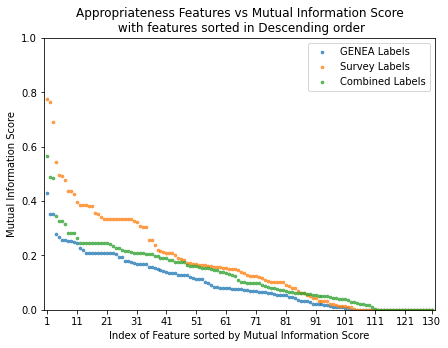

In [89]:
plt.figure(figsize=(7,5))
scores = mutual_info_regression(XX, YY_genea, discrete_features = False)
plt.scatter(np.arange(1,131), np.flip(np.sort(scores)), s=7, alpha = 0.7, label='GENEA Labels')
scores = mutual_info_regression(XX, YY_survey, discrete_features = False)
plt.scatter(np.arange(1,131), np.flip(np.sort(scores)), s=7, alpha = 0.7, label='Survey Labels')
scores = mutual_info_regression(XX, YY_combined, discrete_features = False)
plt.scatter(np.arange(1,131), np.flip(np.sort(scores)), s=7, alpha = 0.7, label='Combined Labels')
plt.xlim(0,131)
plt.ylim(0,1)
plt.title('Appropriateness Features vs Mutual Information Score\n with features sorted in Descending order')
plt.xlabel('Index of Feature sorted by Mutual Information Score')
plt.ylabel('Mutual Information Score')
plt.xticks(np.append(np.arange(1,131,10),130))
plt.legend()

In [90]:
XX_train, XX_test, YY_train_genea, YY_test_genea = train_test_split(XX, YY_genea, test_size=0.2)

In [91]:
train_idx = list(YY_train_genea.index)
test_idx = list(YY_test_genea.index)
YY_train_survey, YY_test_survey = YY_survey.loc[train_idx], YY_survey.loc[test_idx]
YY_train_combined, YY_test_combined = YY_combined.loc[train_idx], YY_combined.loc[test_idx]

In [93]:
def validation_curve(model_name, model, XX, YY, param_grid, log_bool, extra_string, xticks):
    n_splits = 5
    outer_loop_cv = KFold(n_splits = n_splits, shuffle = True)
    outer_val_mse = []
    outer_train_mse = []
    folds = outer_loop_cv.split(XX)
    count = 1
    for train, test in folds:
        XX_train = XX.iloc[train]
        YY_train = YY.iloc[train]
        YY_train = YY_train.values.flatten()
        
        cv_model = GridSearchCV(estimator = model, param_grid = param_grid, scoring = "neg_mean_squared_error", 
                                    cv = KFold(n_splits = 5, shuffle = True), return_train_score=True)
        cv_model.fit(XX_train, YY_train)
        
        train_mse = -1 * cv_model.cv_results_["mean_train_score"]
        val_mse = -1 * cv_model.cv_results_["mean_test_score"]
        
        outer_train_mse = outer_train_mse + [train_mse]
        outer_val_mse = outer_val_mse + [val_mse]
        print('Fold ', count, '/', n_splits, ' Complete.')
        count = count + 1
        
    mean_train_mse = np.mean(np.asarray(outer_train_mse), axis=0)
    mean_val_mse = np.mean(np.asarray(outer_val_mse), axis=0)
    
    train_mse_sem = sem(np.asarray(outer_train_mse), axis=0)
    val_mse_sem = sem(np.asarray(outer_val_mse), axis=0)
    
    param_list = list(np.concatenate(list(param_grid.values())).flat)
    
    plt.figure(figsize = (6,4))
    plt.plot(param_list, mean_train_mse, label='Training Set MSE')
    plt.fill_between(param_list, mean_train_mse - train_mse_sem, mean_train_mse + train_mse_sem, alpha=0.5)
    plt.plot(param_list, mean_val_mse, label='Validation Set MSE')
    plt.fill_between(param_list, mean_val_mse - val_mse_sem, mean_val_mse + val_mse_sem, alpha=0.5)
    if log_bool == True:
        plt.xscale('log')
    plt.xlim(min(param_list),max(param_list))
    plt.xticks(xticks)
    plt.ylim(0, max([max(mean_train_mse), max(mean_val_mse)]) + max([max(train_mse_sem), max(val_mse_sem)]))
    plt.ylabel('MSE')
    plt.xlabel(list(param_grid.keys())[0])
    plt.title(model_name + ' performance on varying ' + list(param_grid.keys())[0] + extra_string)
    plt.legend()
    

In [94]:
# Model name is just the type of algorithm e.g. Linear Regression or kNN
def predicted_vs_true(model_name, model, XX, YY):
    n_splits = 5
    outer_loop_cv = KFold(n_splits = n_splits, shuffle = True)
    folds = outer_loop_cv.split(XX)
    count = 1
    YY_train_true = []
    YY_train_preds = []
    YY_preds = []
    YY_true = []
    for train, test in folds:
        XX_train = XX.iloc[train]
        YY_train = YY.iloc[train]
        XX_test= XX.iloc[test]
        YY_test = YY.iloc[test]
        YY_train, YY_test = YY_train.values.flatten(), YY_test.values.flatten()
        
        model.fit(XX_train, YY_train)
        
        YY_train_preds = YY_train_preds + list(model.predict(XX_train))
        YY_train_true = YY_train_true + list(YY_train)
        
        YY_pred = model.predict(XX_test)
        
        YY_true = YY_true + list(YY_test)
        YY_preds = YY_preds + list(YY_pred)
        print('Fold ', count, '/', n_splits, ' Complete.')
        count = count + 1
    
    
    m, b = np.polyfit(YY_preds, YY_true, 1)
    x = np.arange(0,101)
    y = np.arange(0,101)
    
    plt.figure(figsize = (7,7))
    plt.scatter(YY_preds, YY_true, s=7.5, alpha=0.8, label='Predictions')
    plt.plot(x, y*m + b, '-c', label="Regression Line for predictions")
    plt.plot(x, y, "-k", label="Regression Line for p=1", alpha=0.5)
    plt.title("Predictions of " + model_name + " Model on Test Set")
    plt.ylabel("True Appropriateness")
    plt.xlabel("Predicted Appropriateness")
    plt.xticks(np.linspace(0,100,11))
    plt.yticks(np.linspace(0,100,11))
    plt.xlim(0,100)
    plt.ylim(0,100)
    plt.legend()

    rho, pval = stats.spearmanr(YY_true, YY_preds)
    print("Pearson Correlation Coefficient =", rho)
    print("Test Mean Squared Error = ", mean_squared_error(YY_true, YY_preds, squared=True))
    print("Train Mean Squared Error = ", mean_squared_error(YY_train_true, YY_train_preds, squared=True))

# SVR - GENEA labels

Grid Search Cross Validation for Hyperparameter Tuning

In [97]:
start_time = time.time()

param_grid = {"C": np.logspace(-3, 6, num=10), "gamma": np.logspace(-9, 4, num=14), "epsilon": np.logspace(-3, 6, num=10)}

svr = GridSearchCV(estimator = SVR(kernel = "rbf"), param_grid = param_grid, scoring = "neg_mean_squared_error")

svr.fit(XX_train, YY_train_genea)

svr_init_params = svr.best_params_

print("Time taken: ", time.time() - start_time)

Time taken:  47.10946536064148


In [98]:
print(svr.best_params_)

{'C': 1000.0, 'epsilon': 1.0, 'gamma': 0.01}


Finer Hyperparameter tuning

Tuning epsilon

Fold  1 / 5  Complete.
Fold  2 / 5  Complete.
Fold  3 / 5  Complete.
Fold  4 / 5  Complete.
Fold  5 / 5  Complete.
Time taken:  114.14202809333801


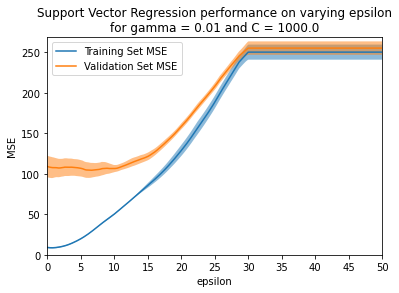

In [99]:
start_time = time.time()
svr = SVR(kernel = "rbf", gamma = svr_init_params['gamma'], C = svr_init_params['C'])
extra_string = '\nfor gamma = ' + str(svr_init_params['gamma']) + ' and C = ' + str(svr_init_params['C'])
param_grid = {"epsilon": np.linspace(0, 50, num=500)}
validation_curve('Support Vector Regression', svr, XX, YY_genea, param_grid, False, extra_string, np.linspace(0, 50, num=11))
print("Time taken: ", time.time() - start_time)

Tuning gamma

Fold  1 / 5  Complete.
Fold  2 / 5  Complete.
Fold  3 / 5  Complete.
Fold  4 / 5  Complete.
Fold  5 / 5  Complete.
Time taken:  117.79833149909973


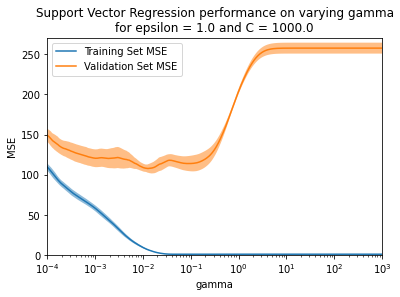

In [100]:
start_time = time.time()
svr = SVR(kernel = "rbf", epsilon = svr_init_params['epsilon'], C = svr_init_params['C'])
extra_string = '\nfor epsilon = ' + str(svr_init_params['epsilon']) + ' and C = ' + str(svr_init_params['C'])
param_grid = {"gamma": np.logspace(-4, 3, num=500)}
validation_curve('Support Vector Regression', svr, XX, YY_genea, param_grid, True, extra_string, np.logspace(-4, 3, num=8))
print("Time taken: ", time.time() - start_time)

Tuning C

Fold  1 / 5  Complete.
Fold  2 / 5  Complete.
Fold  3 / 5  Complete.
Fold  4 / 5  Complete.
Fold  5 / 5  Complete.
Time taken:  115.49337458610535


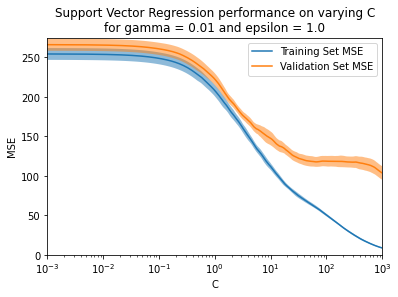

In [101]:
start_time = time.time()
svr = SVR(kernel = "rbf", gamma = svr_init_params['gamma'], epsilon = svr_init_params['epsilon'])
extra_string = '\nfor gamma = ' + str(svr_init_params['gamma']) + ' and epsilon = ' + str(svr_init_params['epsilon'])
param_grid = {"C": np.logspace(-3, 3, num=500)}
validation_curve('Support Vector Regression', svr, XX, YY_genea, param_grid, True, extra_string, np.logspace(-3, 3, num=7))
print("Time taken: ", time.time() - start_time)

Predicted vs True

Fold  1 / 5  Complete.
Fold  2 / 5  Complete.
Fold  3 / 5  Complete.
Fold  4 / 5  Complete.
Fold  5 / 5  Complete.
Pearson Correlation Coefficient = 0.8032121830787424
Test Mean Squared Error =  94.74330359162761
Train Mean Squared Error =  20.326517421597895
Time taken:  1258.5856595039368


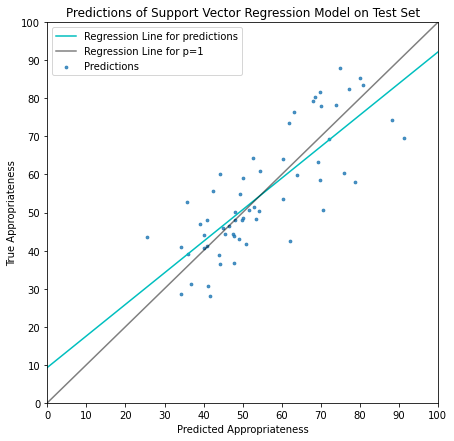

In [102]:
start_time = time.time()
kfolds = KFold(n_splits = 5, shuffle = True)
param_grid = {"C": np.logspace(-3, 3, num=20), "gamma": np.logspace(-4, 3, num=20), "epsilon": np.linspace(0, 50, num=20)}
svr = GridSearchCV(estimator = SVR(kernel = "rbf"), param_grid = param_grid, scoring = "neg_mean_squared_error", cv = kfolds)
predicted_vs_true('Support Vector Regression', svr, XX, YY_genea)
print("Time taken: ", time.time() - start_time)

# SVR - Survey Labels

In [103]:
start_time = time.time()

param_grid = {"C": np.logspace(-3, 6, num=10), "gamma": np.logspace(-9, 4, num=14), "epsilon": np.logspace(-3, 6, num=10)}

svr = GridSearchCV(estimator = SVR(kernel = "rbf"), param_grid = param_grid, scoring = "neg_mean_squared_error")

svr.fit(XX_train, YY_train_survey)

svr_init_params = svr.best_params_

print("Time taken: ", time.time() - start_time)

Time taken:  47.573622703552246


In [104]:
print(svr.best_params_)

{'C': 1000.0, 'epsilon': 0.001, 'gamma': 0.01}


Fold  1 / 5  Complete.
Fold  2 / 5  Complete.
Fold  3 / 5  Complete.
Fold  4 / 5  Complete.
Fold  5 / 5  Complete.
Time taken:  116.90271544456482


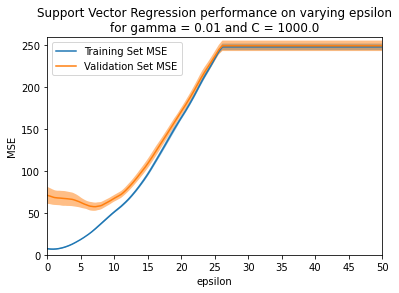

In [105]:
start_time = time.time()
svr = SVR(kernel = "rbf", gamma = svr_init_params['gamma'], C = svr_init_params['C'])
extra_string = '\nfor gamma = ' + str(svr_init_params['gamma']) + ' and C = ' + str(svr_init_params['C'])
param_grid = {"epsilon": np.linspace(0, 50, num=500)}
validation_curve('Support Vector Regression', svr, XX, YY_survey, param_grid, False, extra_string, np.linspace(0, 50, num=11))
print("Time taken: ", time.time() - start_time)

Fold  1 / 5  Complete.
Fold  2 / 5  Complete.
Fold  3 / 5  Complete.
Fold  4 / 5  Complete.
Fold  5 / 5  Complete.
Time taken:  117.43817400932312


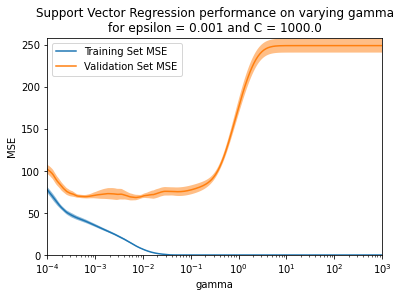

In [106]:
start_time = time.time()
svr = SVR(kernel = "rbf", epsilon = svr_init_params['epsilon'], C = svr_init_params['C'])
extra_string = '\nfor epsilon = ' + str(svr_init_params['epsilon']) + ' and C = ' + str(svr_init_params['C'])
param_grid = {"gamma": np.logspace(-4, 3, num=500)}
validation_curve('Support Vector Regression', svr, XX, YY_survey, param_grid, True, extra_string, np.logspace(-4, 3, num=8))
print("Time taken: ", time.time() - start_time)

Fold  1 / 5  Complete.
Fold  2 / 5  Complete.
Fold  3 / 5  Complete.
Fold  4 / 5  Complete.
Fold  5 / 5  Complete.
Time taken:  114.67164254188538


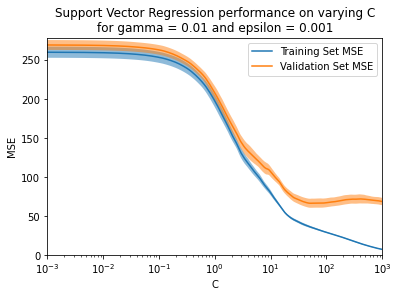

In [107]:
start_time = time.time()
svr = SVR(kernel = "rbf", gamma = svr_init_params['gamma'], epsilon = svr_init_params['epsilon'])
extra_string = '\nfor gamma = ' + str(svr_init_params['gamma']) + ' and epsilon = ' + str(svr_init_params['epsilon'])
param_grid = {"C": np.logspace(-3, 3, num=500)}
validation_curve('Support Vector Regression', svr, XX, YY_survey, param_grid, True, extra_string, np.logspace(-3, 3, num=7))
print("Time taken: ", time.time() - start_time)

Fold  1 / 5  Complete.
Fold  2 / 5  Complete.
Fold  3 / 5  Complete.
Fold  4 / 5  Complete.
Fold  5 / 5  Complete.
Pearson Correlation Coefficient = 0.8335602548440013
Test Mean Squared Error =  58.914186308188796
Train Mean Squared Error =  22.921339993719286
Time taken:  1221.5145208835602


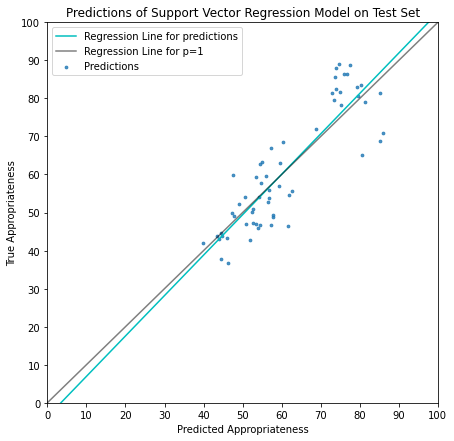

In [108]:
start_time = time.time()
kfolds = KFold(n_splits = 5, shuffle = True)
param_grid = {"C": np.logspace(-3, 3, num=20), "gamma": np.logspace(-4, 3, num=20), "epsilon": np.linspace(0, 50, num=20)}
svr = GridSearchCV(estimator = SVR(kernel = "rbf"), param_grid = param_grid, scoring = "neg_mean_squared_error", cv = kfolds)
predicted_vs_true('Support Vector Regression', svr, XX, YY_survey)
print("Time taken: ", time.time() - start_time)

# SVR - Combined Labels

In [109]:
start_time = time.time()

param_grid = {"C": np.logspace(-3, 6, num=10), "gamma": np.logspace(-9, 4, num=14), "epsilon": np.logspace(-3, 6, num=10)}

svr = GridSearchCV(estimator = SVR(kernel = "rbf"), param_grid = param_grid, scoring = "neg_mean_squared_error")

svr.fit(XX_train, YY_train_combined)

svr_init_params = svr.best_params_

print("Time taken: ", time.time() - start_time)

Time taken:  44.58079266548157


In [110]:
print(svr.best_params_)

{'C': 1000.0, 'epsilon': 1.0, 'gamma': 0.01}


Fold  1 / 5  Complete.
Fold  2 / 5  Complete.
Fold  3 / 5  Complete.
Fold  4 / 5  Complete.
Fold  5 / 5  Complete.
Time taken:  107.4067850112915


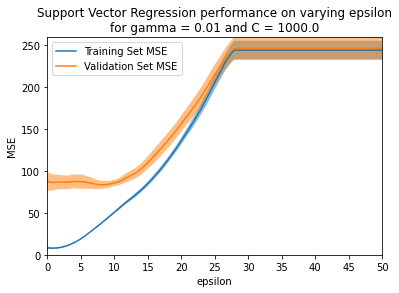

In [111]:
start_time = time.time()
svr = SVR(kernel = "rbf", gamma = svr_init_params['gamma'], C = svr_init_params['C'])
extra_string = '\nfor gamma = ' + str(svr_init_params['gamma']) + ' and C = ' + str(svr_init_params['C'])
param_grid = {"epsilon": np.linspace(0, 50, num=500)}
validation_curve('Support Vector Regression', svr, XX, YY_combined, param_grid, False, extra_string, np.linspace(0, 50, num=11))
print("Time taken: ", time.time() - start_time)

Fold  1 / 5  Complete.
Fold  2 / 5  Complete.
Fold  3 / 5  Complete.
Fold  4 / 5  Complete.
Fold  5 / 5  Complete.
Time taken:  114.35222578048706


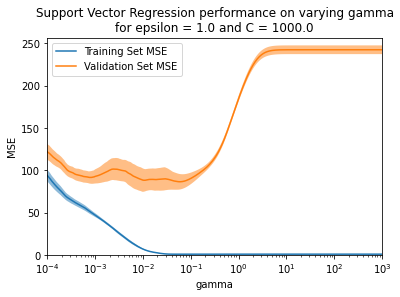

In [112]:
start_time = time.time()
svr = SVR(kernel = "rbf", epsilon = svr_init_params['epsilon'], C = svr_init_params['C'])
extra_string = '\nfor epsilon = ' + str(svr_init_params['epsilon']) + ' and C = ' + str(svr_init_params['C'])
param_grid = {"gamma": np.logspace(-4, 3, num=500)}
validation_curve('Support Vector Regression', svr, XX, YY_combined, param_grid, True, extra_string, np.logspace(-4, 3, num=8))
print("Time taken: ", time.time() - start_time)

Fold  1 / 5  Complete.
Fold  2 / 5  Complete.
Fold  3 / 5  Complete.
Fold  4 / 5  Complete.
Fold  5 / 5  Complete.
Time taken:  128.49735808372498


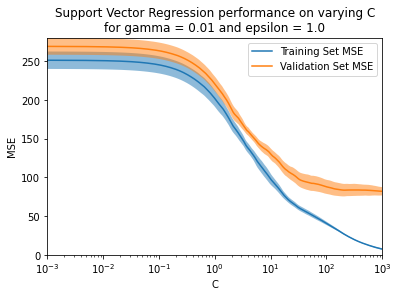

In [113]:
start_time = time.time()
svr = SVR(kernel = "rbf", gamma = svr_init_params['gamma'], epsilon = svr_init_params['epsilon'])
extra_string = '\nfor gamma = ' + str(svr_init_params['gamma']) + ' and epsilon = ' + str(svr_init_params['epsilon'])
param_grid = {"C": np.logspace(-3, 3, num=500)}
validation_curve('Support Vector Regression', svr, XX, YY_combined, param_grid, True, extra_string, np.logspace(-3, 3, num=7))
print("Time taken: ", time.time() - start_time)

Fold  1 / 5  Complete.
Fold  2 / 5  Complete.
Fold  3 / 5  Complete.
Fold  4 / 5  Complete.
Fold  5 / 5  Complete.
Pearson Correlation Coefficient = 0.8032231175326481
Test Mean Squared Error =  87.4730124616026
Train Mean Squared Error =  21.986260856623563
Time taken:  1294.592530965805


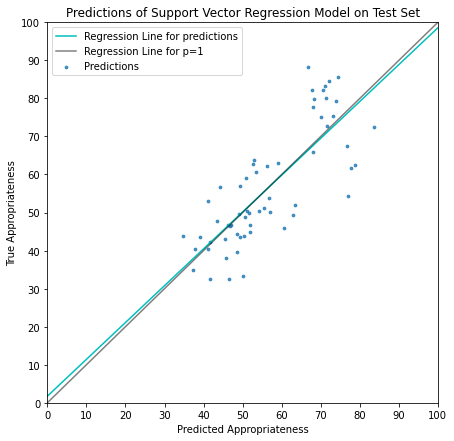

In [114]:
start_time = time.time()
kfolds = KFold(n_splits = 5, shuffle = True)
param_grid = {"C": np.logspace(-3, 3, num=20), "gamma": np.logspace(-4, 3, num=20), "epsilon": np.linspace(0, 50, num=20)}
svr = GridSearchCV(estimator = SVR(kernel = "rbf"), param_grid = param_grid, scoring = "neg_mean_squared_error", cv = kfolds)
predicted_vs_true('Support Vector Regression', svr, XX, YY_combined)
print("Time taken: ", time.time() - start_time)

# Linear Regression - GENEA Labels

Fold  1 / 5  Complete.
Fold  2 / 5  Complete.
Fold  3 / 5  Complete.
Fold  4 / 5  Complete.
Fold  5 / 5  Complete.
Pearson Correlation Coefficient = 0.24969434294421847
Test Mean Squared Error =  882.7916838712121
Train Mean Squared Error =  4.530179950452761e-25
Time taken:  0.15358948707580566


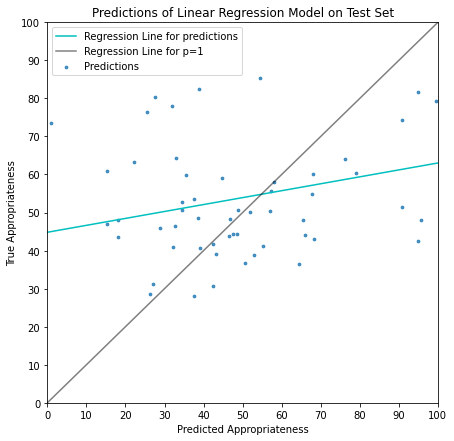

In [115]:
start_time = time.time()
predicted_vs_true('Linear Regression', LinearRegression(), XX, YY_genea)
print("Time taken: ", time.time() - start_time)

# Linear Regression - Survey Labels

Fold  1 / 5  Complete.
Fold  2 / 5  Complete.
Fold  3 / 5  Complete.
Fold  4 / 5  Complete.
Fold  5 / 5  Complete.
Pearson Correlation Coefficient = 0.30620467376848876
Test Mean Squared Error =  1017.8711874816872
Train Mean Squared Error =  5.033195528945129e-25
Time taken:  0.09574484825134277


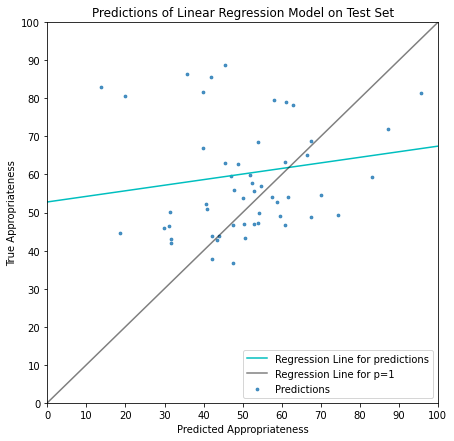

In [116]:
start_time = time.time()
predicted_vs_true('Linear Regression', LinearRegression(), XX, YY_survey)
print("Time taken: ", time.time() - start_time)

# Linear Regression - Combined Labels

Fold  1 / 5  Complete.
Fold  2 / 5  Complete.
Fold  3 / 5  Complete.
Fold  4 / 5  Complete.
Fold  5 / 5  Complete.
Pearson Correlation Coefficient = 0.17388163378716315
Test Mean Squared Error =  674.6697920936177
Train Mean Squared Error =  6.401427437396661e-25
Time taken:  0.09226226806640625


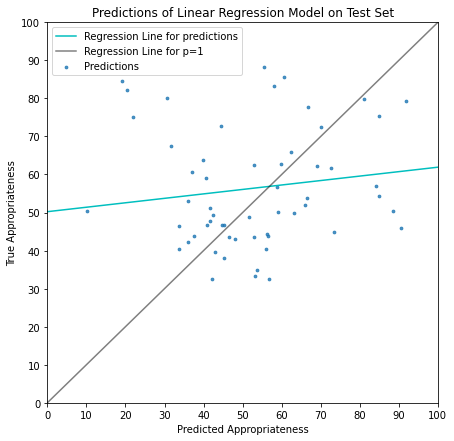

In [117]:
start_time = time.time()
predicted_vs_true('Linear Regression', LinearRegression(), XX, YY_combined)
print("Time taken: ", time.time() - start_time)

# Ridge Regression - GENEA Labels

Tuning alpha

Fold  1 / 5  Complete.
Fold  2 / 5  Complete.
Fold  3 / 5  Complete.
Fold  4 / 5  Complete.
Fold  5 / 5  Complete.
Time taken:  220.03565454483032


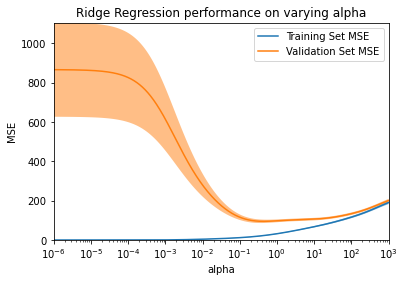

In [118]:
start_time = time.time()
validation_curve('Ridge Regression', Ridge(), XX, YY_genea, {"alpha": np.logspace(-6,3, 1000)}, True, '', np.logspace(-6,3,10))
print("Time taken: ", time.time() - start_time)

Predicted vs True

Fold  1 / 5  Complete.
Fold  2 / 5  Complete.
Fold  3 / 5  Complete.
Fold  4 / 5  Complete.
Fold  5 / 5  Complete.
Pearson Correlation Coefficient = 0.7447482505665417
Test Mean Squared Error =  105.8895261171979
Train Mean Squared Error =  28.796164531732042
Time taken:  179.21383476257324


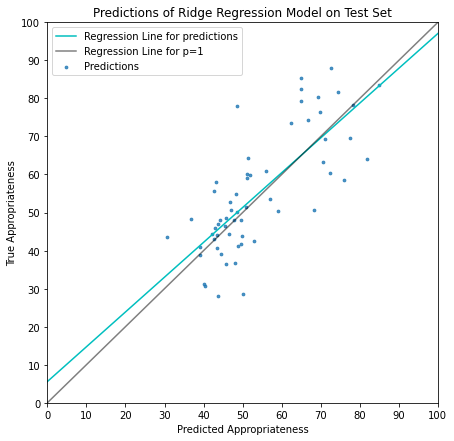

In [119]:
start_time = time.time()
kfolds = KFold(n_splits = 5, shuffle = True)
param_grid = {"alpha": np.logspace(-6,3, 1000)}
ridge_model = GridSearchCV(estimator = Ridge(), param_grid = param_grid, scoring = "neg_mean_squared_error", cv = kfolds)
predicted_vs_true('Ridge Regression', ridge_model, XX, YY_genea)
print("Time taken: ", time.time() - start_time)

# Ridge Regression - Survey Labels

Fold  1 / 5  Complete.
Fold  2 / 5  Complete.
Fold  3 / 5  Complete.
Fold  4 / 5  Complete.
Fold  5 / 5  Complete.
Time taken:  244.09295749664307


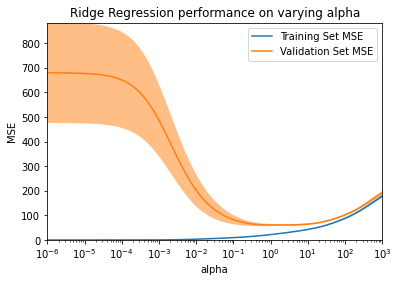

In [120]:
start_time = time.time()
validation_curve('Ridge Regression', Ridge(), XX, YY_survey, {"alpha": np.logspace(-6,3, 1000)}, True, '', np.logspace(-6,3,10))
print("Time taken: ", time.time() - start_time)

Fold  1 / 5  Complete.
Fold  2 / 5  Complete.
Fold  3 / 5  Complete.
Fold  4 / 5  Complete.
Fold  5 / 5  Complete.
Pearson Correlation Coefficient = 0.7904359668504719
Test Mean Squared Error =  62.91339180177483
Train Mean Squared Error =  31.138917922695917
Time taken:  176.9119484424591


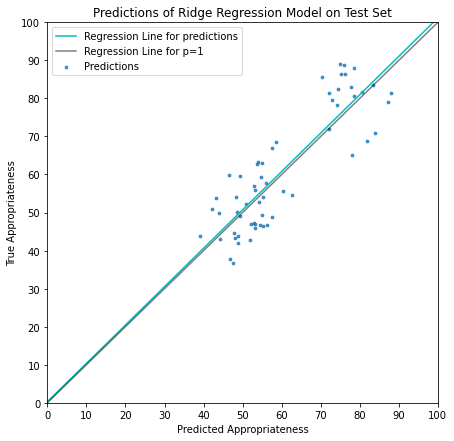

In [121]:
start_time = time.time()
kfolds = KFold(n_splits = 5, shuffle = True)
param_grid = {"alpha": np.logspace(-6,3, 1000)}
ridge_model = GridSearchCV(estimator = Ridge(), param_grid = param_grid, scoring = "neg_mean_squared_error", cv = kfolds)
predicted_vs_true('Ridge Regression', ridge_model, XX, YY_survey)
print("Time taken: ", time.time() - start_time)

# Ridge Regression - Combined Labels

Fold  1 / 5  Complete.
Fold  2 / 5  Complete.
Fold  3 / 5  Complete.
Fold  4 / 5  Complete.
Fold  5 / 5  Complete.
Time taken:  243.3626000881195


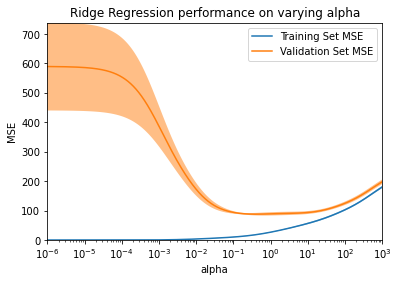

In [122]:
start_time = time.time()
validation_curve('Ridge Regression', Ridge(), XX, YY_combined, {"alpha": np.logspace(-6,3, 1000)}, True, '', np.logspace(-6,3,10))
print("Time taken: ", time.time() - start_time)

Fold  1 / 5  Complete.
Fold  2 / 5  Complete.
Fold  3 / 5  Complete.
Fold  4 / 5  Complete.
Fold  5 / 5  Complete.
Pearson Correlation Coefficient = 0.7987774381772716
Test Mean Squared Error =  88.2139347689127
Train Mean Squared Error =  46.84130100467548
Time taken:  172.97374606132507


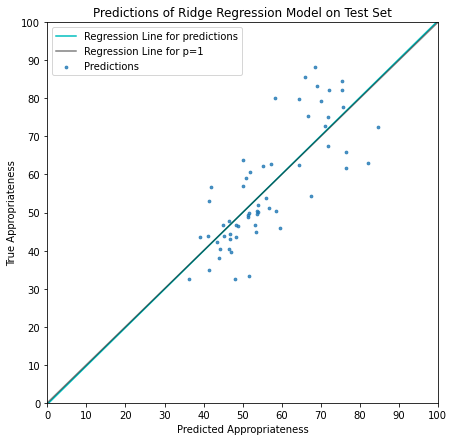

In [123]:
start_time = time.time()
kfolds = KFold(n_splits = 5, shuffle = True)
param_grid = {"alpha": np.logspace(-6,3, 1000)}
ridge_model = GridSearchCV(estimator = Ridge(), param_grid = param_grid, scoring = "neg_mean_squared_error", cv = kfolds)
predicted_vs_true('Ridge Regression', ridge_model, XX, YY_combined)
print("Time taken: ", time.time() - start_time)

# Kernel Ridge Regression - GENEA Labels

Grid Search for hyperparameter intialisations

In [124]:
start_time = time.time()

param_grid = {"alpha": np.logspace(-10,5, 16), "gamma": np.logspace(-10, 5, 16)}
kfolds = KFold(n_splits = 5, shuffle = True)
krr = GridSearchCV(estimator = KernelRidge(kernel = "rbf"), param_grid = param_grid, scoring = "neg_mean_squared_error", cv=kfolds, verbose = 3)
krr.fit(XX_train, YY_train_genea)

krr_init_params = krr.best_params_
print("Time taken: ", time.time() - start_time)

Fitting 5 folds for each of 256 candidates, totalling 1280 fits
[CV 1/5] END .......................alpha=1e-10, gamma=1e-10; total time=   0.0s
[CV 2/5] END .......................alpha=1e-10, gamma=1e-10; total time=   0.0s
[CV 3/5] END .......................alpha=1e-10, gamma=1e-10; total time=   0.0s
[CV 4/5] END .......................alpha=1e-10, gamma=1e-10; total time=   0.0s
[CV 5/5] END .......................alpha=1e-10, gamma=1e-10; total time=   0.0s
[CV 1/5] END .......................alpha=1e-10, gamma=1e-09; total time=   0.0s
[CV 2/5] END .......................alpha=1e-10, gamma=1e-09; total time=   0.0s
[CV 3/5] END .......................alpha=1e-10, gamma=1e-09; total time=   0.0s
[CV 4/5] END .......................alpha=1e-10, gamma=1e-09; total time=   0.0s
[CV 5/5] END .......................alpha=1e-10, gamma=1e-09; total time=   0.0s
[CV 1/5] END .......................alpha=1e-10, gamma=1e-08; total time=   0.0s
[CV 2/5] END .......................alpha=1e-

[CV 2/5] END .......................alpha=1e-09, gamma=1e-06; total time=   0.0s
[CV 3/5] END .......................alpha=1e-09, gamma=1e-06; total time=   0.0s
[CV 4/5] END .......................alpha=1e-09, gamma=1e-06; total time=   0.0s
[CV 5/5] END .......................alpha=1e-09, gamma=1e-06; total time=   0.0s
[CV 1/5] END .......................alpha=1e-09, gamma=1e-05; total time=   0.0s
[CV 2/5] END .......................alpha=1e-09, gamma=1e-05; total time=   0.0s
[CV 3/5] END .......................alpha=1e-09, gamma=1e-05; total time=   0.0s
[CV 4/5] END .......................alpha=1e-09, gamma=1e-05; total time=   0.0s
[CV 5/5] END .......................alpha=1e-09, gamma=1e-05; total time=   0.0s
[CV 1/5] END ......................alpha=1e-09, gamma=0.0001; total time=   0.0s
[CV 2/5] END ......................alpha=1e-09, gamma=0.0001; total time=   0.0s
[CV 3/5] END ......................alpha=1e-09, gamma=0.0001; total time=   0.0s
[CV 4/5] END ...............

[CV 4/5] END ........................alpha=1e-08, gamma=0.01; total time=   0.0s
[CV 5/5] END ........................alpha=1e-08, gamma=0.01; total time=   0.0s
[CV 1/5] END .........................alpha=1e-08, gamma=0.1; total time=   0.0s
[CV 2/5] END .........................alpha=1e-08, gamma=0.1; total time=   0.0s
[CV 3/5] END .........................alpha=1e-08, gamma=0.1; total time=   0.0s
[CV 4/5] END .........................alpha=1e-08, gamma=0.1; total time=   0.0s
[CV 5/5] END .........................alpha=1e-08, gamma=0.1; total time=   0.0s
[CV 1/5] END .........................alpha=1e-08, gamma=1.0; total time=   0.0s
[CV 2/5] END .........................alpha=1e-08, gamma=1.0; total time=   0.0s
[CV 3/5] END .........................alpha=1e-08, gamma=1.0; total time=   0.0s
[CV 4/5] END .........................alpha=1e-08, gamma=1.0; total time=   0.0s
[CV 5/5] END .........................alpha=1e-08, gamma=1.0; total time=   0.0s
[CV 1/5] END ...............

[CV 5/5] END .......................alpha=1e-06, gamma=1e-09; total time=   0.0s
[CV 1/5] END .......................alpha=1e-06, gamma=1e-08; total time=   0.0s
[CV 2/5] END .......................alpha=1e-06, gamma=1e-08; total time=   0.0s
[CV 3/5] END .......................alpha=1e-06, gamma=1e-08; total time=   0.0s
[CV 4/5] END .......................alpha=1e-06, gamma=1e-08; total time=   0.0s
[CV 5/5] END .......................alpha=1e-06, gamma=1e-08; total time=   0.0s
[CV 1/5] END .......................alpha=1e-06, gamma=1e-07; total time=   0.0s
[CV 2/5] END .......................alpha=1e-06, gamma=1e-07; total time=   0.0s
[CV 3/5] END .......................alpha=1e-06, gamma=1e-07; total time=   0.0s
[CV 4/5] END .......................alpha=1e-06, gamma=1e-07; total time=   0.0s
[CV 5/5] END .......................alpha=1e-06, gamma=1e-07; total time=   0.0s
[CV 1/5] END .......................alpha=1e-06, gamma=1e-06; total time=   0.0s
[CV 2/5] END ...............

[CV 3/5] END ........................alpha=1e-05, gamma=0.01; total time=   0.0s
[CV 4/5] END ........................alpha=1e-05, gamma=0.01; total time=   0.0s
[CV 5/5] END ........................alpha=1e-05, gamma=0.01; total time=   0.0s
[CV 1/5] END .........................alpha=1e-05, gamma=0.1; total time=   0.0s
[CV 2/5] END .........................alpha=1e-05, gamma=0.1; total time=   0.0s
[CV 3/5] END .........................alpha=1e-05, gamma=0.1; total time=   0.0s
[CV 4/5] END .........................alpha=1e-05, gamma=0.1; total time=   0.0s
[CV 5/5] END .........................alpha=1e-05, gamma=0.1; total time=   0.0s
[CV 1/5] END .........................alpha=1e-05, gamma=1.0; total time=   0.0s
[CV 2/5] END .........................alpha=1e-05, gamma=1.0; total time=   0.0s
[CV 3/5] END .........................alpha=1e-05, gamma=1.0; total time=   0.0s
[CV 4/5] END .........................alpha=1e-05, gamma=1.0; total time=   0.0s
[CV 5/5] END ...............

[CV 5/5] END .......................alpha=0.001, gamma=1e-10; total time=   0.0s
[CV 1/5] END .......................alpha=0.001, gamma=1e-09; total time=   0.0s
[CV 2/5] END .......................alpha=0.001, gamma=1e-09; total time=   0.0s
[CV 3/5] END .......................alpha=0.001, gamma=1e-09; total time=   0.0s
[CV 4/5] END .......................alpha=0.001, gamma=1e-09; total time=   0.0s
[CV 5/5] END .......................alpha=0.001, gamma=1e-09; total time=   0.0s
[CV 1/5] END .......................alpha=0.001, gamma=1e-08; total time=   0.0s
[CV 2/5] END .......................alpha=0.001, gamma=1e-08; total time=   0.0s
[CV 3/5] END .......................alpha=0.001, gamma=1e-08; total time=   0.0s
[CV 4/5] END .......................alpha=0.001, gamma=1e-08; total time=   0.0s
[CV 5/5] END .......................alpha=0.001, gamma=1e-08; total time=   0.0s
[CV 1/5] END .......................alpha=0.001, gamma=1e-07; total time=   0.0s
[CV 2/5] END ...............

[CV 4/5] END ........................alpha=0.01, gamma=0.001; total time=   0.0s
[CV 5/5] END ........................alpha=0.01, gamma=0.001; total time=   0.0s
[CV 1/5] END .........................alpha=0.01, gamma=0.01; total time=   0.0s
[CV 2/5] END .........................alpha=0.01, gamma=0.01; total time=   0.0s
[CV 3/5] END .........................alpha=0.01, gamma=0.01; total time=   0.0s
[CV 4/5] END .........................alpha=0.01, gamma=0.01; total time=   0.0s
[CV 5/5] END .........................alpha=0.01, gamma=0.01; total time=   0.0s
[CV 1/5] END ..........................alpha=0.01, gamma=0.1; total time=   0.0s
[CV 2/5] END ..........................alpha=0.01, gamma=0.1; total time=   0.0s
[CV 3/5] END ..........................alpha=0.01, gamma=0.1; total time=   0.0s
[CV 4/5] END ..........................alpha=0.01, gamma=0.1; total time=   0.0s
[CV 5/5] END ..........................alpha=0.01, gamma=0.1; total time=   0.0s
[CV 1/5] END ...............

[CV 3/5] END .......................alpha=0.1, gamma=10000.0; total time=   0.0s
[CV 4/5] END .......................alpha=0.1, gamma=10000.0; total time=   0.0s
[CV 5/5] END .......................alpha=0.1, gamma=10000.0; total time=   0.0s
[CV 1/5] END ......................alpha=0.1, gamma=100000.0; total time=   0.0s
[CV 2/5] END ......................alpha=0.1, gamma=100000.0; total time=   0.0s
[CV 3/5] END ......................alpha=0.1, gamma=100000.0; total time=   0.0s
[CV 4/5] END ......................alpha=0.1, gamma=100000.0; total time=   0.0s
[CV 5/5] END ......................alpha=0.1, gamma=100000.0; total time=   0.0s
[CV 1/5] END .........................alpha=1.0, gamma=1e-10; total time=   0.0s
[CV 2/5] END .........................alpha=1.0, gamma=1e-10; total time=   0.0s
[CV 3/5] END .........................alpha=1.0, gamma=1e-10; total time=   0.0s
[CV 4/5] END .........................alpha=1.0, gamma=1e-10; total time=   0.0s
[CV 5/5] END ...............

[CV 5/5] END ........................alpha=10.0, gamma=1e-07; total time=   0.0s
[CV 1/5] END ........................alpha=10.0, gamma=1e-06; total time=   0.0s
[CV 2/5] END ........................alpha=10.0, gamma=1e-06; total time=   0.0s
[CV 3/5] END ........................alpha=10.0, gamma=1e-06; total time=   0.0s
[CV 4/5] END ........................alpha=10.0, gamma=1e-06; total time=   0.0s
[CV 5/5] END ........................alpha=10.0, gamma=1e-06; total time=   0.0s
[CV 1/5] END ........................alpha=10.0, gamma=1e-05; total time=   0.0s
[CV 2/5] END ........................alpha=10.0, gamma=1e-05; total time=   0.0s
[CV 3/5] END ........................alpha=10.0, gamma=1e-05; total time=   0.0s
[CV 4/5] END ........................alpha=10.0, gamma=1e-05; total time=   0.0s
[CV 5/5] END ........................alpha=10.0, gamma=1e-05; total time=   0.0s
[CV 1/5] END .......................alpha=10.0, gamma=0.0001; total time=   0.0s
[CV 2/5] END ...............

[CV 4/5] END .........................alpha=100.0, gamma=1.0; total time=   0.0s
[CV 5/5] END .........................alpha=100.0, gamma=1.0; total time=   0.0s
[CV 1/5] END ........................alpha=100.0, gamma=10.0; total time=   0.0s
[CV 2/5] END ........................alpha=100.0, gamma=10.0; total time=   0.0s
[CV 3/5] END ........................alpha=100.0, gamma=10.0; total time=   0.0s
[CV 4/5] END ........................alpha=100.0, gamma=10.0; total time=   0.0s
[CV 5/5] END ........................alpha=100.0, gamma=10.0; total time=   0.0s
[CV 1/5] END .......................alpha=100.0, gamma=100.0; total time=   0.0s
[CV 2/5] END .......................alpha=100.0, gamma=100.0; total time=   0.0s
[CV 3/5] END .......................alpha=100.0, gamma=100.0; total time=   0.0s
[CV 4/5] END .......................alpha=100.0, gamma=100.0; total time=   0.0s
[CV 5/5] END .......................alpha=100.0, gamma=100.0; total time=   0.0s
[CV 1/5] END ...............

[CV 2/5] END .....................alpha=10000.0, gamma=1e-07; total time=   0.0s
[CV 3/5] END .....................alpha=10000.0, gamma=1e-07; total time=   0.0s
[CV 4/5] END .....................alpha=10000.0, gamma=1e-07; total time=   0.0s
[CV 5/5] END .....................alpha=10000.0, gamma=1e-07; total time=   0.0s
[CV 1/5] END .....................alpha=10000.0, gamma=1e-06; total time=   0.0s
[CV 2/5] END .....................alpha=10000.0, gamma=1e-06; total time=   0.0s
[CV 3/5] END .....................alpha=10000.0, gamma=1e-06; total time=   0.0s
[CV 4/5] END .....................alpha=10000.0, gamma=1e-06; total time=   0.0s
[CV 5/5] END .....................alpha=10000.0, gamma=1e-06; total time=   0.0s
[CV 1/5] END .....................alpha=10000.0, gamma=1e-05; total time=   0.0s
[CV 2/5] END .....................alpha=10000.0, gamma=1e-05; total time=   0.0s
[CV 3/5] END .....................alpha=10000.0, gamma=1e-05; total time=   0.0s
[CV 4/5] END ...............

[CV 3/5] END ......................alpha=100000.0, gamma=1.0; total time=   0.0s
[CV 4/5] END ......................alpha=100000.0, gamma=1.0; total time=   0.0s
[CV 5/5] END ......................alpha=100000.0, gamma=1.0; total time=   0.0s
[CV 1/5] END .....................alpha=100000.0, gamma=10.0; total time=   0.0s
[CV 2/5] END .....................alpha=100000.0, gamma=10.0; total time=   0.0s
[CV 3/5] END .....................alpha=100000.0, gamma=10.0; total time=   0.0s
[CV 4/5] END .....................alpha=100000.0, gamma=10.0; total time=   0.0s
[CV 5/5] END .....................alpha=100000.0, gamma=10.0; total time=   0.0s
[CV 1/5] END ....................alpha=100000.0, gamma=100.0; total time=   0.0s
[CV 2/5] END ....................alpha=100000.0, gamma=100.0; total time=   0.0s
[CV 3/5] END ....................alpha=100000.0, gamma=100.0; total time=   0.0s
[CV 4/5] END ....................alpha=100000.0, gamma=100.0; total time=   0.0s
[CV 5/5] END ...............

In [125]:
print(krr_init_params)

{'alpha': 1e-10, 'gamma': 1e-10}


Tuning Alpha

Fold  1 / 5  Complete.
Fold  2 / 5  Complete.
Fold  3 / 5  Complete.
Fold  4 / 5  Complete.
Fold  5 / 5  Complete.
Time taken:  256.757018327713


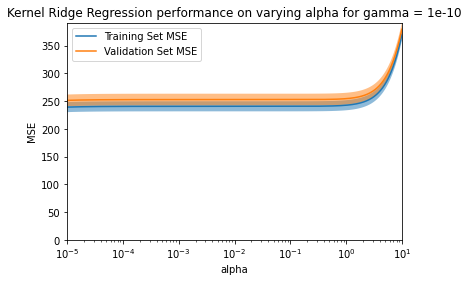

In [126]:
start_time = time.time()
krr = KernelRidge(kernel = "rbf", gamma = krr_init_params['gamma'])
extra_string = ' for gamma = ' + str(krr_init_params['gamma'])
param_grid = {"alpha": np.logspace(-5,1, 1000)}
validation_curve('Kernel Ridge Regression', krr, XX, YY_genea, param_grid, True, extra_string, np.logspace(-5,1, 7))
print("Time taken: ", time.time() - start_time)

Tuning Gamma

Fold  1 / 5  Complete.
Fold  2 / 5  Complete.
Fold  3 / 5  Complete.
Fold  4 / 5  Complete.
Fold  5 / 5  Complete.
Time taken:  263.416570186615


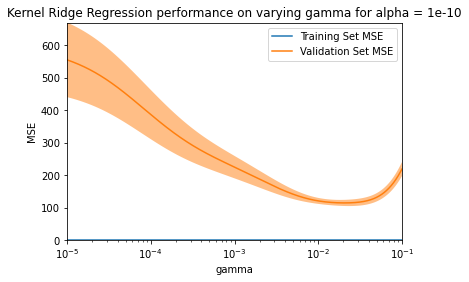

In [127]:
start_time = time.time()
krr = KernelRidge(kernel = "rbf", alpha = krr_init_params['alpha'])
extra_string = ' for alpha = ' + str(krr_init_params['alpha'])
param_grid = {"gamma": np.logspace(-5,-1, 1000)}
validation_curve('Kernel Ridge Regression', krr, XX, YY_genea, param_grid, True, extra_string, np.logspace(-5,-1, 5))
print("Time taken: ", time.time() - start_time)

Predicted vs True

Fold  1 / 5  Complete.
Fold  2 / 5  Complete.
Fold  3 / 5  Complete.
Fold  4 / 5  Complete.
Fold  5 / 5  Complete.
Pearson Correlation Coefficient = 0.7876514405850008
Test Mean Squared Error =  113.77421704950456
Train Mean Squared Error =  24.216377000538248
Time taken:  467.93502378463745


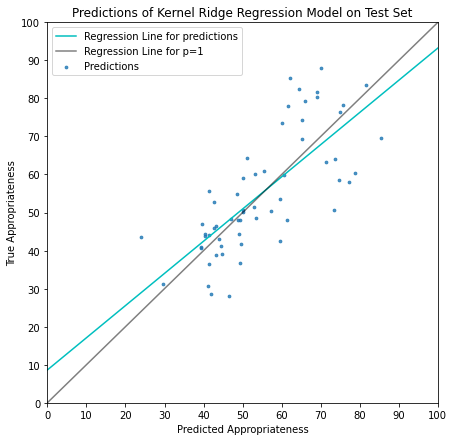

In [128]:
start_time = time.time()
kfolds = KFold(n_splits = 5, shuffle = True)
param_grid = {"alpha": np.logspace(-5,1, 50), "gamma": np.logspace(-5,-1, 50)}
krr_model = GridSearchCV(estimator = KernelRidge(kernel = "rbf"), param_grid = param_grid, scoring = "neg_mean_squared_error", cv = kfolds)
predicted_vs_true('Kernel Ridge Regression', krr_model, XX, YY_genea)
print("Time taken: ", time.time() - start_time)

# Kernel Ridge Regression - Survey Labels

In [129]:
start_time = time.time()

param_grid = {"alpha": np.logspace(-10,5, 16), "gamma": np.logspace(-10, 5, 16)}
kfolds = KFold(n_splits = 5, shuffle = True)
krr = GridSearchCV(estimator = KernelRidge(kernel = "rbf"), param_grid = param_grid, scoring = "neg_mean_squared_error", cv=kfolds, verbose = 3)
krr.fit(XX_train, YY_train_survey)

krr_init_params = krr.best_params_
print("Time taken: ", time.time() - start_time)

Fitting 5 folds for each of 256 candidates, totalling 1280 fits
[CV 1/5] END .......................alpha=1e-10, gamma=1e-10; total time=   0.0s
[CV 2/5] END .......................alpha=1e-10, gamma=1e-10; total time=   0.0s
[CV 3/5] END .......................alpha=1e-10, gamma=1e-10; total time=   0.0s
[CV 4/5] END .......................alpha=1e-10, gamma=1e-10; total time=   0.0s
[CV 5/5] END .......................alpha=1e-10, gamma=1e-10; total time=   0.0s
[CV 1/5] END .......................alpha=1e-10, gamma=1e-09; total time=   0.0s
[CV 2/5] END .......................alpha=1e-10, gamma=1e-09; total time=   0.0s
[CV 3/5] END .......................alpha=1e-10, gamma=1e-09; total time=   0.0s
[CV 4/5] END .......................alpha=1e-10, gamma=1e-09; total time=   0.0s
[CV 5/5] END .......................alpha=1e-10, gamma=1e-09; total time=   0.0s
[CV 1/5] END .......................alpha=1e-10, gamma=1e-08; total time=   0.0s
[CV 2/5] END .......................alpha=1e-

[CV 4/5] END .......................alpha=1e-09, gamma=0.001; total time=   0.0s
[CV 5/5] END .......................alpha=1e-09, gamma=0.001; total time=   0.0s
[CV 1/5] END ........................alpha=1e-09, gamma=0.01; total time=   0.0s
[CV 2/5] END ........................alpha=1e-09, gamma=0.01; total time=   0.0s
[CV 3/5] END ........................alpha=1e-09, gamma=0.01; total time=   0.0s
[CV 4/5] END ........................alpha=1e-09, gamma=0.01; total time=   0.0s
[CV 5/5] END ........................alpha=1e-09, gamma=0.01; total time=   0.0s
[CV 1/5] END .........................alpha=1e-09, gamma=0.1; total time=   0.0s
[CV 2/5] END .........................alpha=1e-09, gamma=0.1; total time=   0.0s
[CV 3/5] END .........................alpha=1e-09, gamma=0.1; total time=   0.0s
[CV 4/5] END .........................alpha=1e-09, gamma=0.1; total time=   0.0s
[CV 5/5] END .........................alpha=1e-09, gamma=0.1; total time=   0.0s
[CV 1/5] END ...............

[CV 1/5] END .....................alpha=1e-08, gamma=10000.0; total time=   0.0s
[CV 2/5] END .....................alpha=1e-08, gamma=10000.0; total time=   0.0s
[CV 3/5] END .....................alpha=1e-08, gamma=10000.0; total time=   0.0s
[CV 4/5] END .....................alpha=1e-08, gamma=10000.0; total time=   0.0s
[CV 5/5] END .....................alpha=1e-08, gamma=10000.0; total time=   0.0s
[CV 1/5] END ....................alpha=1e-08, gamma=100000.0; total time=   0.0s
[CV 2/5] END ....................alpha=1e-08, gamma=100000.0; total time=   0.0s
[CV 3/5] END ....................alpha=1e-08, gamma=100000.0; total time=   0.0s
[CV 4/5] END ....................alpha=1e-08, gamma=100000.0; total time=   0.0s
[CV 5/5] END ....................alpha=1e-08, gamma=100000.0; total time=   0.0s
[CV 1/5] END .......................alpha=1e-07, gamma=1e-10; total time=   0.0s
[CV 2/5] END .......................alpha=1e-07, gamma=1e-10; total time=   0.0s
[CV 3/5] END ...............

[CV 3/5] END .......................alpha=1e-06, gamma=1e-07; total time=   0.0s
[CV 4/5] END .......................alpha=1e-06, gamma=1e-07; total time=   0.0s
[CV 5/5] END .......................alpha=1e-06, gamma=1e-07; total time=   0.0s
[CV 1/5] END .......................alpha=1e-06, gamma=1e-06; total time=   0.0s
[CV 2/5] END .......................alpha=1e-06, gamma=1e-06; total time=   0.0s
[CV 3/5] END .......................alpha=1e-06, gamma=1e-06; total time=   0.0s
[CV 4/5] END .......................alpha=1e-06, gamma=1e-06; total time=   0.0s
[CV 5/5] END .......................alpha=1e-06, gamma=1e-06; total time=   0.0s
[CV 1/5] END .......................alpha=1e-06, gamma=1e-05; total time=   0.0s
[CV 2/5] END .......................alpha=1e-06, gamma=1e-05; total time=   0.0s
[CV 3/5] END .......................alpha=1e-06, gamma=1e-05; total time=   0.0s
[CV 4/5] END .......................alpha=1e-06, gamma=1e-05; total time=   0.0s
[CV 5/5] END ...............

[CV 1/5] END ........................alpha=1e-05, gamma=10.0; total time=   0.0s
[CV 2/5] END ........................alpha=1e-05, gamma=10.0; total time=   0.0s
[CV 3/5] END ........................alpha=1e-05, gamma=10.0; total time=   0.0s
[CV 4/5] END ........................alpha=1e-05, gamma=10.0; total time=   0.0s
[CV 5/5] END ........................alpha=1e-05, gamma=10.0; total time=   0.0s
[CV 1/5] END .......................alpha=1e-05, gamma=100.0; total time=   0.0s
[CV 2/5] END .......................alpha=1e-05, gamma=100.0; total time=   0.0s
[CV 3/5] END .......................alpha=1e-05, gamma=100.0; total time=   0.0s
[CV 4/5] END .......................alpha=1e-05, gamma=100.0; total time=   0.0s
[CV 5/5] END .......................alpha=1e-05, gamma=100.0; total time=   0.0s
[CV 1/5] END ......................alpha=1e-05, gamma=1000.0; total time=   0.0s
[CV 2/5] END ......................alpha=1e-05, gamma=1000.0; total time=   0.0s
[CV 3/5] END ...............

[CV 5/5] END .......................alpha=0.001, gamma=1e-08; total time=   0.0s
[CV 1/5] END .......................alpha=0.001, gamma=1e-07; total time=   0.0s
[CV 2/5] END .......................alpha=0.001, gamma=1e-07; total time=   0.0s
[CV 3/5] END .......................alpha=0.001, gamma=1e-07; total time=   0.0s
[CV 4/5] END .......................alpha=0.001, gamma=1e-07; total time=   0.0s
[CV 5/5] END .......................alpha=0.001, gamma=1e-07; total time=   0.0s
[CV 1/5] END .......................alpha=0.001, gamma=1e-06; total time=   0.0s
[CV 2/5] END .......................alpha=0.001, gamma=1e-06; total time=   0.0s
[CV 3/5] END .......................alpha=0.001, gamma=1e-06; total time=   0.0s
[CV 4/5] END .......................alpha=0.001, gamma=1e-06; total time=   0.0s
[CV 5/5] END .......................alpha=0.001, gamma=1e-06; total time=   0.0s
[CV 1/5] END .......................alpha=0.001, gamma=1e-05; total time=   0.0s
[CV 2/5] END ...............

[CV 4/5] END ..........................alpha=0.01, gamma=0.1; total time=   0.0s
[CV 5/5] END ..........................alpha=0.01, gamma=0.1; total time=   0.0s
[CV 1/5] END ..........................alpha=0.01, gamma=1.0; total time=   0.0s
[CV 2/5] END ..........................alpha=0.01, gamma=1.0; total time=   0.0s
[CV 3/5] END ..........................alpha=0.01, gamma=1.0; total time=   0.0s
[CV 4/5] END ..........................alpha=0.01, gamma=1.0; total time=   0.0s
[CV 5/5] END ..........................alpha=0.01, gamma=1.0; total time=   0.0s
[CV 1/5] END .........................alpha=0.01, gamma=10.0; total time=   0.0s
[CV 2/5] END .........................alpha=0.01, gamma=10.0; total time=   0.0s
[CV 3/5] END .........................alpha=0.01, gamma=10.0; total time=   0.0s
[CV 4/5] END .........................alpha=0.01, gamma=10.0; total time=   0.0s
[CV 5/5] END .........................alpha=0.01, gamma=10.0; total time=   0.0s
[CV 1/5] END ...............

[CV 2/5] END ......................alpha=0.1, gamma=100000.0; total time=   0.0s
[CV 3/5] END ......................alpha=0.1, gamma=100000.0; total time=   0.0s
[CV 4/5] END ......................alpha=0.1, gamma=100000.0; total time=   0.0s
[CV 5/5] END ......................alpha=0.1, gamma=100000.0; total time=   0.0s
[CV 1/5] END .........................alpha=1.0, gamma=1e-10; total time=   0.0s
[CV 2/5] END .........................alpha=1.0, gamma=1e-10; total time=   0.0s
[CV 3/5] END .........................alpha=1.0, gamma=1e-10; total time=   0.0s
[CV 4/5] END .........................alpha=1.0, gamma=1e-10; total time=   0.0s
[CV 5/5] END .........................alpha=1.0, gamma=1e-10; total time=   0.0s
[CV 1/5] END .........................alpha=1.0, gamma=1e-09; total time=   0.0s
[CV 2/5] END .........................alpha=1.0, gamma=1e-09; total time=   0.0s
[CV 3/5] END .........................alpha=1.0, gamma=1e-09; total time=   0.0s
[CV 4/5] END ...............

[CV 4/5] END ........................alpha=10.0, gamma=1e-05; total time=   0.0s
[CV 5/5] END ........................alpha=10.0, gamma=1e-05; total time=   0.0s
[CV 1/5] END .......................alpha=10.0, gamma=0.0001; total time=   0.0s
[CV 2/5] END .......................alpha=10.0, gamma=0.0001; total time=   0.0s
[CV 3/5] END .......................alpha=10.0, gamma=0.0001; total time=   0.0s
[CV 4/5] END .......................alpha=10.0, gamma=0.0001; total time=   0.0s
[CV 5/5] END .......................alpha=10.0, gamma=0.0001; total time=   0.0s
[CV 1/5] END ........................alpha=10.0, gamma=0.001; total time=   0.0s
[CV 2/5] END ........................alpha=10.0, gamma=0.001; total time=   0.0s
[CV 3/5] END ........................alpha=10.0, gamma=0.001; total time=   0.0s
[CV 4/5] END ........................alpha=10.0, gamma=0.001; total time=   0.0s
[CV 5/5] END ........................alpha=10.0, gamma=0.001; total time=   0.0s
[CV 1/5] END ...............

[CV 3/5] END ........................alpha=100.0, gamma=10.0; total time=   0.0s
[CV 4/5] END ........................alpha=100.0, gamma=10.0; total time=   0.0s
[CV 5/5] END ........................alpha=100.0, gamma=10.0; total time=   0.0s
[CV 1/5] END .......................alpha=100.0, gamma=100.0; total time=   0.0s
[CV 2/5] END .......................alpha=100.0, gamma=100.0; total time=   0.0s
[CV 3/5] END .......................alpha=100.0, gamma=100.0; total time=   0.0s
[CV 4/5] END .......................alpha=100.0, gamma=100.0; total time=   0.0s
[CV 5/5] END .......................alpha=100.0, gamma=100.0; total time=   0.0s
[CV 1/5] END ......................alpha=100.0, gamma=1000.0; total time=   0.0s
[CV 2/5] END ......................alpha=100.0, gamma=1000.0; total time=   0.0s
[CV 3/5] END ......................alpha=100.0, gamma=1000.0; total time=   0.0s
[CV 4/5] END ......................alpha=100.0, gamma=1000.0; total time=   0.0s
[CV 5/5] END ...............

[CV 1/5] END .....................alpha=10000.0, gamma=1e-09; total time=   0.0s
[CV 2/5] END .....................alpha=10000.0, gamma=1e-09; total time=   0.0s
[CV 3/5] END .....................alpha=10000.0, gamma=1e-09; total time=   0.0s
[CV 4/5] END .....................alpha=10000.0, gamma=1e-09; total time=   0.0s
[CV 5/5] END .....................alpha=10000.0, gamma=1e-09; total time=   0.0s
[CV 1/5] END .....................alpha=10000.0, gamma=1e-08; total time=   0.0s
[CV 2/5] END .....................alpha=10000.0, gamma=1e-08; total time=   0.0s
[CV 3/5] END .....................alpha=10000.0, gamma=1e-08; total time=   0.0s
[CV 4/5] END .....................alpha=10000.0, gamma=1e-08; total time=   0.0s
[CV 5/5] END .....................alpha=10000.0, gamma=1e-08; total time=   0.0s
[CV 1/5] END .....................alpha=10000.0, gamma=1e-07; total time=   0.0s
[CV 2/5] END .....................alpha=10000.0, gamma=1e-07; total time=   0.0s
[CV 3/5] END ...............

[CV 1/5] END .....................alpha=100000.0, gamma=0.01; total time=   0.0s
[CV 2/5] END .....................alpha=100000.0, gamma=0.01; total time=   0.0s
[CV 3/5] END .....................alpha=100000.0, gamma=0.01; total time=   0.0s
[CV 4/5] END .....................alpha=100000.0, gamma=0.01; total time=   0.0s
[CV 5/5] END .....................alpha=100000.0, gamma=0.01; total time=   0.0s
[CV 1/5] END ......................alpha=100000.0, gamma=0.1; total time=   0.0s
[CV 2/5] END ......................alpha=100000.0, gamma=0.1; total time=   0.0s
[CV 3/5] END ......................alpha=100000.0, gamma=0.1; total time=   0.0s
[CV 4/5] END ......................alpha=100000.0, gamma=0.1; total time=   0.0s
[CV 5/5] END ......................alpha=100000.0, gamma=0.1; total time=   0.0s
[CV 1/5] END ......................alpha=100000.0, gamma=1.0; total time=   0.0s
[CV 2/5] END ......................alpha=100000.0, gamma=1.0; total time=   0.0s
[CV 3/5] END ...............

Fold  1 / 5  Complete.
Fold  2 / 5  Complete.
Fold  3 / 5  Complete.
Fold  4 / 5  Complete.
Fold  5 / 5  Complete.
Time taken:  441.035010099411


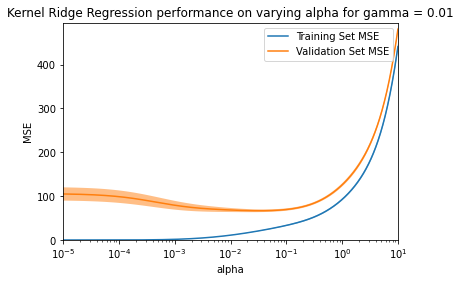

In [130]:
start_time = time.time()
krr = KernelRidge(kernel = "rbf", gamma = krr_init_params['gamma'])
extra_string = ' for gamma = ' + str(krr_init_params['gamma'])
param_grid = {"alpha": np.logspace(-5,1, 1000)}
validation_curve('Kernel Ridge Regression', krr, XX, YY_survey, param_grid, True, extra_string, np.logspace(-5,1, 7))
print("Time taken: ", time.time() - start_time)

Fold  1 / 5  Complete.
Fold  2 / 5  Complete.
Fold  3 / 5  Complete.
Fold  4 / 5  Complete.
Fold  5 / 5  Complete.
Time taken:  267.223552942276


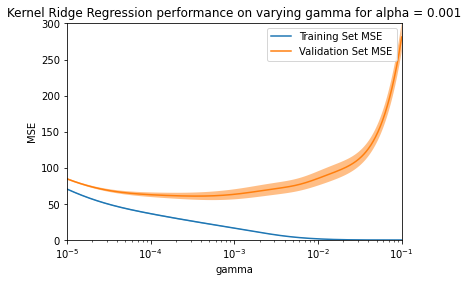

In [131]:
start_time = time.time()
krr = KernelRidge(kernel = "rbf", alpha = krr_init_params['alpha'])
extra_string = ' for alpha = ' + str(krr_init_params['alpha'])
param_grid = {"gamma": np.logspace(-5,-1, 1000)}
validation_curve('Kernel Ridge Regression', krr, XX, YY_survey, param_grid, True, extra_string, np.logspace(-5,-1, 5))
print("Time taken: ", time.time() - start_time)

Fold  1 / 5  Complete.
Fold  2 / 5  Complete.
Fold  3 / 5  Complete.
Fold  4 / 5  Complete.
Fold  5 / 5  Complete.
Pearson Correlation Coefficient = 0.7865458893252825
Test Mean Squared Error =  68.49672552025187
Train Mean Squared Error =  17.60860908778828
Time taken:  494.81568789482117


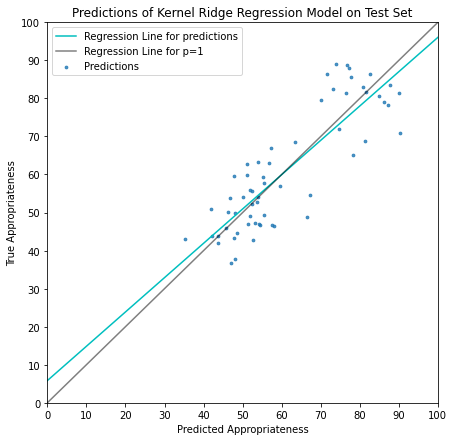

In [132]:
start_time = time.time()
kfolds = KFold(n_splits = 5, shuffle = True)
param_grid = {"alpha": np.logspace(-5,1, 50), "gamma": np.logspace(-5,-1, 50)}
krr_model = GridSearchCV(estimator = KernelRidge(kernel = "rbf"), param_grid = param_grid, scoring = "neg_mean_squared_error", cv = kfolds)
predicted_vs_true('Kernel Ridge Regression', krr_model, XX, YY_survey)
print("Time taken: ", time.time() - start_time)

# Kernel Ridge Regression - Combined Labels

In [133]:
start_time = time.time()

param_grid = {"alpha": np.logspace(-10,5, 16), "gamma": np.logspace(-10, 5, 16)}
kfolds = KFold(n_splits = 5, shuffle = True)
krr = GridSearchCV(estimator = KernelRidge(kernel = "rbf"), param_grid = param_grid, scoring = "neg_mean_squared_error", cv=kfolds, verbose = 3)
krr.fit(XX_train, YY_train_combined)

krr_init_params = krr.best_params_
print("Time taken: ", time.time() - start_time)

Fitting 5 folds for each of 256 candidates, totalling 1280 fits
[CV 1/5] END .......................alpha=1e-10, gamma=1e-10; total time=   0.0s
[CV 2/5] END .......................alpha=1e-10, gamma=1e-10; total time=   0.0s
[CV 3/5] END .......................alpha=1e-10, gamma=1e-10; total time=   0.0s
[CV 4/5] END .......................alpha=1e-10, gamma=1e-10; total time=   0.0s
[CV 5/5] END .......................alpha=1e-10, gamma=1e-10; total time=   0.0s
[CV 1/5] END .......................alpha=1e-10, gamma=1e-09; total time=   0.0s
[CV 2/5] END .......................alpha=1e-10, gamma=1e-09; total time=   0.0s
[CV 3/5] END .......................alpha=1e-10, gamma=1e-09; total time=   0.0s
[CV 4/5] END .......................alpha=1e-10, gamma=1e-09; total time=   0.0s
[CV 5/5] END .......................alpha=1e-10, gamma=1e-09; total time=   0.0s
[CV 1/5] END .......................alpha=1e-10, gamma=1e-08; total time=   0.0s
[CV 2/5] END .......................alpha=1e-

[CV 5/5] END ......................alpha=1e-09, gamma=0.0001; total time=   0.0s
[CV 1/5] END .......................alpha=1e-09, gamma=0.001; total time=   0.0s
[CV 2/5] END .......................alpha=1e-09, gamma=0.001; total time=   0.0s
[CV 3/5] END .......................alpha=1e-09, gamma=0.001; total time=   0.0s
[CV 4/5] END .......................alpha=1e-09, gamma=0.001; total time=   0.0s
[CV 5/5] END .......................alpha=1e-09, gamma=0.001; total time=   0.0s
[CV 1/5] END ........................alpha=1e-09, gamma=0.01; total time=   0.0s
[CV 2/5] END ........................alpha=1e-09, gamma=0.01; total time=   0.0s
[CV 3/5] END ........................alpha=1e-09, gamma=0.01; total time=   0.0s
[CV 4/5] END ........................alpha=1e-09, gamma=0.01; total time=   0.0s
[CV 5/5] END ........................alpha=1e-09, gamma=0.01; total time=   0.0s
[CV 1/5] END .........................alpha=1e-09, gamma=0.1; total time=   0.0s
[CV 2/5] END ...............

[CV 1/5] END ....................alpha=1e-08, gamma=100000.0; total time=   0.0s
[CV 2/5] END ....................alpha=1e-08, gamma=100000.0; total time=   0.0s
[CV 3/5] END ....................alpha=1e-08, gamma=100000.0; total time=   0.0s
[CV 4/5] END ....................alpha=1e-08, gamma=100000.0; total time=   0.0s
[CV 5/5] END ....................alpha=1e-08, gamma=100000.0; total time=   0.0s
[CV 1/5] END .......................alpha=1e-07, gamma=1e-10; total time=   0.0s
[CV 2/5] END .......................alpha=1e-07, gamma=1e-10; total time=   0.0s
[CV 3/5] END .......................alpha=1e-07, gamma=1e-10; total time=   0.0s
[CV 4/5] END .......................alpha=1e-07, gamma=1e-10; total time=   0.0s
[CV 5/5] END .......................alpha=1e-07, gamma=1e-10; total time=   0.0s
[CV 1/5] END .......................alpha=1e-07, gamma=1e-09; total time=   0.0s
[CV 2/5] END .......................alpha=1e-07, gamma=1e-09; total time=   0.0s
[CV 3/5] END ...............

[CV 1/5] END ........................alpha=1e-06, gamma=0.01; total time=   0.0s
[CV 2/5] END ........................alpha=1e-06, gamma=0.01; total time=   0.0s
[CV 3/5] END ........................alpha=1e-06, gamma=0.01; total time=   0.0s
[CV 4/5] END ........................alpha=1e-06, gamma=0.01; total time=   0.0s
[CV 5/5] END ........................alpha=1e-06, gamma=0.01; total time=   0.0s
[CV 1/5] END .........................alpha=1e-06, gamma=0.1; total time=   0.0s
[CV 2/5] END .........................alpha=1e-06, gamma=0.1; total time=   0.0s
[CV 3/5] END .........................alpha=1e-06, gamma=0.1; total time=   0.0s
[CV 4/5] END .........................alpha=1e-06, gamma=0.1; total time=   0.0s
[CV 5/5] END .........................alpha=1e-06, gamma=0.1; total time=   0.0s
[CV 1/5] END .........................alpha=1e-06, gamma=1.0; total time=   0.0s
[CV 2/5] END .........................alpha=1e-06, gamma=1.0; total time=   0.0s
[CV 3/5] END ...............

[CV 4/5] END ......................alpha=0.0001, gamma=1e-10; total time=   0.0s
[CV 5/5] END ......................alpha=0.0001, gamma=1e-10; total time=   0.0s
[CV 1/5] END ......................alpha=0.0001, gamma=1e-09; total time=   0.0s
[CV 2/5] END ......................alpha=0.0001, gamma=1e-09; total time=   0.0s
[CV 3/5] END ......................alpha=0.0001, gamma=1e-09; total time=   0.0s
[CV 4/5] END ......................alpha=0.0001, gamma=1e-09; total time=   0.0s
[CV 5/5] END ......................alpha=0.0001, gamma=1e-09; total time=   0.0s
[CV 1/5] END ......................alpha=0.0001, gamma=1e-08; total time=   0.0s
[CV 2/5] END ......................alpha=0.0001, gamma=1e-08; total time=   0.0s
[CV 3/5] END ......................alpha=0.0001, gamma=1e-08; total time=   0.0s
[CV 4/5] END ......................alpha=0.0001, gamma=1e-08; total time=   0.0s
[CV 5/5] END ......................alpha=0.0001, gamma=1e-08; total time=   0.0s
[CV 1/5] END ...............

[CV 1/5] END .........................alpha=0.001, gamma=0.1; total time=   0.0s
[CV 2/5] END .........................alpha=0.001, gamma=0.1; total time=   0.0s
[CV 3/5] END .........................alpha=0.001, gamma=0.1; total time=   0.0s
[CV 4/5] END .........................alpha=0.001, gamma=0.1; total time=   0.0s
[CV 5/5] END .........................alpha=0.001, gamma=0.1; total time=   0.0s
[CV 1/5] END .........................alpha=0.001, gamma=1.0; total time=   0.0s
[CV 2/5] END .........................alpha=0.001, gamma=1.0; total time=   0.0s
[CV 3/5] END .........................alpha=0.001, gamma=1.0; total time=   0.0s
[CV 4/5] END .........................alpha=0.001, gamma=1.0; total time=   0.0s
[CV 5/5] END .........................alpha=0.001, gamma=1.0; total time=   0.0s
[CV 1/5] END ........................alpha=0.001, gamma=10.0; total time=   0.0s
[CV 2/5] END ........................alpha=0.001, gamma=10.0; total time=   0.0s
[CV 3/5] END ...............

[CV 3/5] END .........................alpha=0.1, gamma=1e-10; total time=   0.0s
[CV 4/5] END .........................alpha=0.1, gamma=1e-10; total time=   0.0s
[CV 5/5] END .........................alpha=0.1, gamma=1e-10; total time=   0.0s
[CV 1/5] END .........................alpha=0.1, gamma=1e-09; total time=   0.0s
[CV 2/5] END .........................alpha=0.1, gamma=1e-09; total time=   0.0s
[CV 3/5] END .........................alpha=0.1, gamma=1e-09; total time=   0.0s
[CV 4/5] END .........................alpha=0.1, gamma=1e-09; total time=   0.0s
[CV 5/5] END .........................alpha=0.1, gamma=1e-09; total time=   0.0s
[CV 1/5] END .........................alpha=0.1, gamma=1e-08; total time=   0.0s
[CV 2/5] END .........................alpha=0.1, gamma=1e-08; total time=   0.0s
[CV 3/5] END .........................alpha=0.1, gamma=1e-08; total time=   0.0s
[CV 4/5] END .........................alpha=0.1, gamma=1e-08; total time=   0.0s
[CV 5/5] END ...............

[CV 5/5] END ..........................alpha=1.0, gamma=0.01; total time=   0.0s
[CV 1/5] END ...........................alpha=1.0, gamma=0.1; total time=   0.0s
[CV 2/5] END ...........................alpha=1.0, gamma=0.1; total time=   0.0s
[CV 3/5] END ...........................alpha=1.0, gamma=0.1; total time=   0.0s
[CV 4/5] END ...........................alpha=1.0, gamma=0.1; total time=   0.0s
[CV 5/5] END ...........................alpha=1.0, gamma=0.1; total time=   0.0s
[CV 1/5] END ...........................alpha=1.0, gamma=1.0; total time=   0.0s
[CV 2/5] END ...........................alpha=1.0, gamma=1.0; total time=   0.0s
[CV 3/5] END ...........................alpha=1.0, gamma=1.0; total time=   0.0s
[CV 4/5] END ...........................alpha=1.0, gamma=1.0; total time=   0.0s
[CV 5/5] END ...........................alpha=1.0, gamma=1.0; total time=   0.0s
[CV 1/5] END ..........................alpha=1.0, gamma=10.0; total time=   0.0s
[CV 2/5] END ...............

[CV 2/5] END .......................alpha=100.0, gamma=1e-09; total time=   0.0s
[CV 3/5] END .......................alpha=100.0, gamma=1e-09; total time=   0.0s
[CV 4/5] END .......................alpha=100.0, gamma=1e-09; total time=   0.0s
[CV 5/5] END .......................alpha=100.0, gamma=1e-09; total time=   0.0s
[CV 1/5] END .......................alpha=100.0, gamma=1e-08; total time=   0.0s
[CV 2/5] END .......................alpha=100.0, gamma=1e-08; total time=   0.0s
[CV 3/5] END .......................alpha=100.0, gamma=1e-08; total time=   0.0s
[CV 4/5] END .......................alpha=100.0, gamma=1e-08; total time=   0.0s
[CV 5/5] END .......................alpha=100.0, gamma=1e-08; total time=   0.0s
[CV 1/5] END .......................alpha=100.0, gamma=1e-07; total time=   0.0s
[CV 2/5] END .......................alpha=100.0, gamma=1e-07; total time=   0.0s
[CV 3/5] END .......................alpha=100.0, gamma=1e-07; total time=   0.0s
[CV 4/5] END ...............

[CV 4/5] END .......................alpha=1000.0, gamma=0.01; total time=   0.0s
[CV 5/5] END .......................alpha=1000.0, gamma=0.01; total time=   0.0s
[CV 1/5] END ........................alpha=1000.0, gamma=0.1; total time=   0.0s
[CV 2/5] END ........................alpha=1000.0, gamma=0.1; total time=   0.0s
[CV 3/5] END ........................alpha=1000.0, gamma=0.1; total time=   0.0s
[CV 4/5] END ........................alpha=1000.0, gamma=0.1; total time=   0.0s
[CV 5/5] END ........................alpha=1000.0, gamma=0.1; total time=   0.0s
[CV 1/5] END ........................alpha=1000.0, gamma=1.0; total time=   0.0s
[CV 2/5] END ........................alpha=1000.0, gamma=1.0; total time=   0.0s
[CV 3/5] END ........................alpha=1000.0, gamma=1.0; total time=   0.0s
[CV 4/5] END ........................alpha=1000.0, gamma=1.0; total time=   0.0s
[CV 5/5] END ........................alpha=1000.0, gamma=1.0; total time=   0.0s
[CV 1/5] END ...............

[CV 1/5] END ....................alpha=100000.0, gamma=1e-09; total time=   0.0s
[CV 2/5] END ....................alpha=100000.0, gamma=1e-09; total time=   0.0s
[CV 3/5] END ....................alpha=100000.0, gamma=1e-09; total time=   0.0s
[CV 4/5] END ....................alpha=100000.0, gamma=1e-09; total time=   0.0s
[CV 5/5] END ....................alpha=100000.0, gamma=1e-09; total time=   0.0s
[CV 1/5] END ....................alpha=100000.0, gamma=1e-08; total time=   0.0s
[CV 2/5] END ....................alpha=100000.0, gamma=1e-08; total time=   0.0s
[CV 3/5] END ....................alpha=100000.0, gamma=1e-08; total time=   0.0s
[CV 4/5] END ....................alpha=100000.0, gamma=1e-08; total time=   0.0s
[CV 5/5] END ....................alpha=100000.0, gamma=1e-08; total time=   0.0s
[CV 1/5] END ....................alpha=100000.0, gamma=1e-07; total time=   0.0s
[CV 2/5] END ....................alpha=100000.0, gamma=1e-07; total time=   0.0s
[CV 3/5] END ...............

Fold  1 / 5  Complete.
Fold  2 / 5  Complete.
Fold  3 / 5  Complete.
Fold  4 / 5  Complete.
Fold  5 / 5  Complete.
Time taken:  263.26546120643616


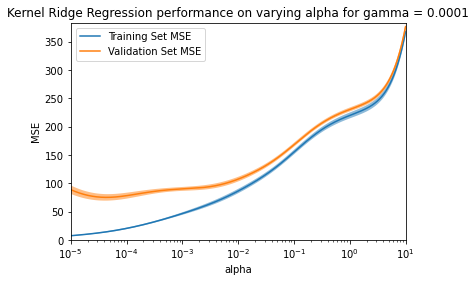

In [134]:
start_time = time.time()
krr = KernelRidge(kernel = "rbf", gamma = krr_init_params['gamma'])
extra_string = ' for gamma = ' + str(krr_init_params['gamma'])
param_grid = {"alpha": np.logspace(-5,1, 1000)}
validation_curve('Kernel Ridge Regression', krr, XX, YY_combined, param_grid, True, extra_string, np.logspace(-5,1, 7))
print("Time taken: ", time.time() - start_time)

Fold  1 / 5  Complete.
Fold  2 / 5  Complete.
Fold  3 / 5  Complete.
Fold  4 / 5  Complete.
Fold  5 / 5  Complete.
Time taken:  270.8110201358795


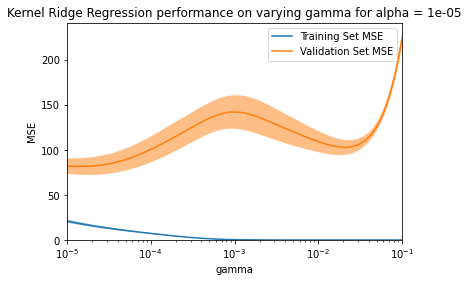

In [135]:
start_time = time.time()
krr = KernelRidge(kernel = "rbf", alpha = krr_init_params['alpha'])
extra_string = ' for alpha = ' + str(krr_init_params['alpha'])
param_grid = {"gamma": np.logspace(-5,-1, 1000)}
validation_curve('Kernel Ridge Regression', krr, XX, YY_combined, param_grid, True, extra_string, np.logspace(-5,-1, 5))
print("Time taken: ", time.time() - start_time)

Fold  1 / 5  Complete.
Fold  2 / 5  Complete.
Fold  3 / 5  Complete.
Fold  4 / 5  Complete.
Fold  5 / 5  Complete.
Pearson Correlation Coefficient = 0.8456237843845514
Test Mean Squared Error =  81.98809606772019
Train Mean Squared Error =  17.53491618640178
Time taken:  482.6163055896759


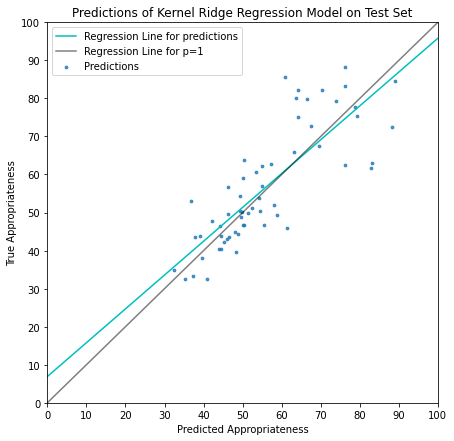

In [136]:
start_time = time.time()
kfolds = KFold(n_splits = 5, shuffle = True)
param_grid = {"alpha": np.logspace(-5,1, 50), "gamma": np.logspace(-5,-1, 50)}
krr_model = GridSearchCV(estimator = KernelRidge(kernel = "rbf"), param_grid = param_grid, scoring = "neg_mean_squared_error", cv = kfolds)
predicted_vs_true('Kernel Ridge Regression', krr_model, XX, YY_combined)
print("Time taken: ", time.time() - start_time)

# kNN Regression - GENEA Labels

Tune n_neighbors for weights = "uniform"

Fold  1 / 5  Complete.
Fold  2 / 5  Complete.
Fold  3 / 5  Complete.
Fold  4 / 5  Complete.
Fold  5 / 5  Complete.
Time taken:  2.4300379753112793


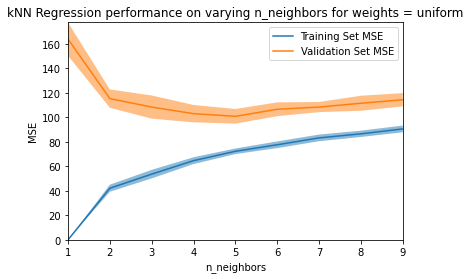

In [137]:
start_time = time.time()
knn = KNeighborsRegressor(weights = 'uniform')
extra_string = ' for weights = uniform'
param_grid = {"n_neighbors": np.arange(1,10,1)}
validation_curve('kNN Regression', knn, XX, YY_genea, param_grid, False, extra_string, np.arange(1,10,1))
print("Time taken: ", time.time() - start_time)

Tune n_neighbors for weights = "distance"

Fold  1 / 5  Complete.
Fold  2 / 5  Complete.
Fold  3 / 5  Complete.
Fold  4 / 5  Complete.
Fold  5 / 5  Complete.
Time taken:  2.8070263862609863


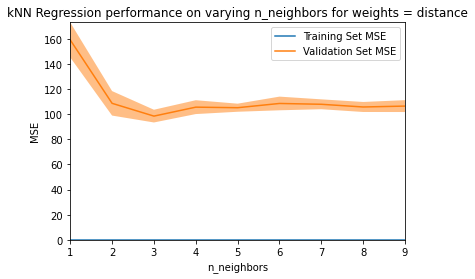

In [138]:
start_time = time.time()
knn = KNeighborsRegressor(weights = 'distance')
extra_string = ' for weights = distance'
param_grid = {"n_neighbors": np.arange(1,10,1)}
validation_curve('kNN Regression', knn, XX, YY_genea, param_grid, False, extra_string, np.arange(1,10,1))
print("Time taken: ", time.time() - start_time)

Predicted VS True

Fold  1 / 5  Complete.
Fold  2 / 5  Complete.
Fold  3 / 5  Complete.
Fold  4 / 5  Complete.
Fold  5 / 5  Complete.
Pearson Correlation Coefficient = 0.7506495317392413
Test Mean Squared Error =  107.10872619087601
Train Mean Squared Error =  34.48833310591777
Time taken:  3.6889266967773438


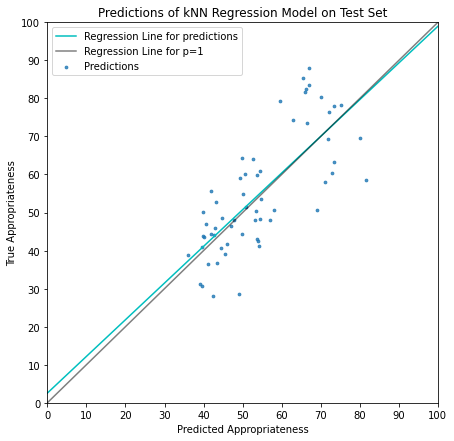

In [139]:
start_time = time.time()
kfolds = KFold(n_splits = 5, shuffle = True)
param_grid = {"n_neighbors": np.arange(1,10,1), "weights": ["uniform", "distance"]}
knn_model = GridSearchCV(estimator = KNeighborsRegressor(), param_grid = param_grid, scoring = "neg_mean_squared_error", cv = kfolds)
predicted_vs_true('kNN Regression', knn_model, XX, YY_genea)
print("Time taken: ", time.time() - start_time)

# kNN Regression - Survey Labels

Fold  1 / 5  Complete.
Fold  2 / 5  Complete.
Fold  3 / 5  Complete.
Fold  4 / 5  Complete.
Fold  5 / 5  Complete.
Time taken:  2.6739938259124756


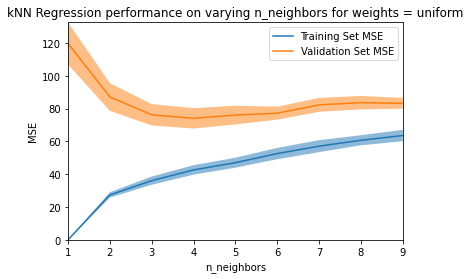

In [140]:
start_time = time.time()
knn = KNeighborsRegressor(weights = 'uniform')
extra_string = ' for weights = uniform'
param_grid = {"n_neighbors": np.arange(1,10,1)}
validation_curve('kNN Regression', knn, XX, YY_survey, param_grid, False, extra_string, np.arange(1,10,1))
print("Time taken: ", time.time() - start_time)

Fold  1 / 5  Complete.
Fold  2 / 5  Complete.
Fold  3 / 5  Complete.
Fold  4 / 5  Complete.
Fold  5 / 5  Complete.
Time taken:  2.916043758392334


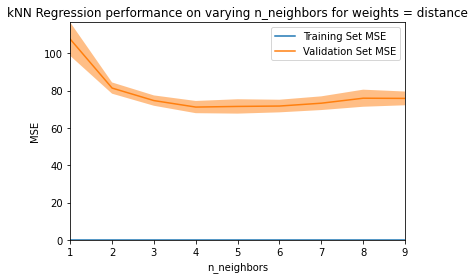

In [141]:
start_time = time.time()
knn = KNeighborsRegressor(weights = 'distance')
extra_string = ' for weights = distance'
param_grid = {"n_neighbors": np.arange(1,10,1)}
validation_curve('kNN Regression', knn, XX, YY_survey, param_grid, False, extra_string, np.arange(1,10,1))
print("Time taken: ", time.time() - start_time)

Fold  1 / 5  Complete.
Fold  2 / 5  Complete.
Fold  3 / 5  Complete.
Fold  4 / 5  Complete.
Fold  5 / 5  Complete.
Pearson Correlation Coefficient = 0.7936256529954429
Test Mean Squared Error =  70.97039017994378
Train Mean Squared Error =  13.803270833390139
Time taken:  3.421037435531616


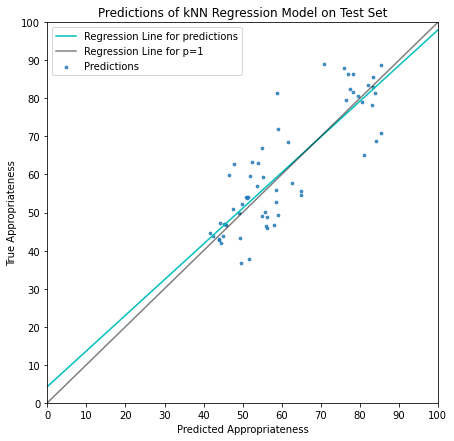

In [142]:
start_time = time.time()
kfolds = KFold(n_splits = 5, shuffle = True)
param_grid = {"n_neighbors": np.arange(1,10,1), "weights": ["uniform", "distance"]}
knn_model = GridSearchCV(estimator = KNeighborsRegressor(), param_grid = param_grid, scoring = "neg_mean_squared_error", cv = kfolds)
predicted_vs_true('kNN Regression', knn_model, XX, YY_survey)
print("Time taken: ", time.time() - start_time)

# kNN Regression - Combined Labels

Fold  1 / 5  Complete.
Fold  2 / 5  Complete.
Fold  3 / 5  Complete.
Fold  4 / 5  Complete.
Fold  5 / 5  Complete.
Time taken:  2.5030081272125244


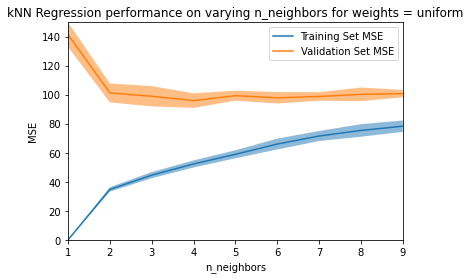

In [143]:
start_time = time.time()
knn = KNeighborsRegressor(weights = 'uniform')
extra_string = ' for weights = uniform'
param_grid = {"n_neighbors": np.arange(1,10,1)}
validation_curve('kNN Regression', knn, XX, YY_combined, param_grid, False, extra_string, np.arange(1,10,1))
print("Time taken: ", time.time() - start_time)

Fold  1 / 5  Complete.
Fold  2 / 5  Complete.
Fold  3 / 5  Complete.
Fold  4 / 5  Complete.
Fold  5 / 5  Complete.
Time taken:  2.4938759803771973


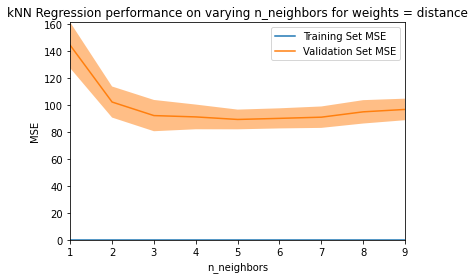

In [144]:
start_time = time.time()
knn = KNeighborsRegressor(weights = 'distance')
extra_string = ' for weights = distance'
param_grid = {"n_neighbors": np.arange(1,10,1)}
validation_curve('kNN Regression', knn, XX, YY_combined, param_grid, False, extra_string, np.arange(1,10,1))
print("Time taken: ", time.time() - start_time)

Fold  1 / 5  Complete.
Fold  2 / 5  Complete.
Fold  3 / 5  Complete.
Fold  4 / 5  Complete.
Fold  5 / 5  Complete.
Pearson Correlation Coefficient = 0.7684783828694977
Test Mean Squared Error =  83.47744756598597
Train Mean Squared Error =  32.51672284924641
Time taken:  3.4469456672668457


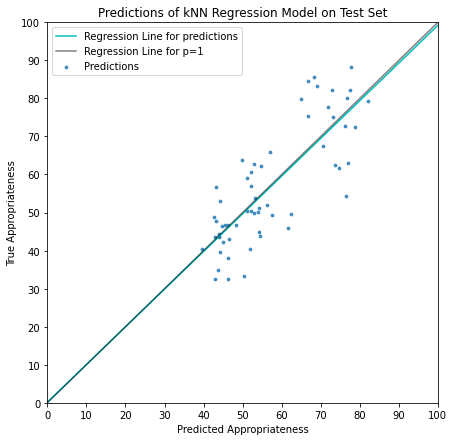

In [145]:
start_time = time.time()
kfolds = KFold(n_splits = 5, shuffle = True)
param_grid = {"n_neighbors": np.arange(1,10,1), "weights": ["uniform", "distance"]}
knn_model = GridSearchCV(estimator = KNeighborsRegressor(), param_grid = param_grid, scoring = "neg_mean_squared_error", cv = kfolds)
predicted_vs_true('kNN Regression', knn_model, XX, YY_combined)
print("Time taken: ", time.time() - start_time)

# Variances

In [149]:
print('GENEA Variance: ',np.var(YY_genea))
print('Survey Variance: ',np.var(YY_survey))
print('Combined Variance: ',np.var(YY_combined))

print('GENEA Mean: ',np.mean(YY_genea))
print('Survey Mean: ',np.mean(YY_survey))
print('Combined Mean: ',np.mean(YY_combined))

GENEA Variance:  242.5964333381107
Survey Variance:  243.0189555555556
Combined Variance:  233.76206479293478
GENEA Mean:  54.990339044400756
Survey Mean:  61.10666666666669
Combined Mean:  56.58708996785561


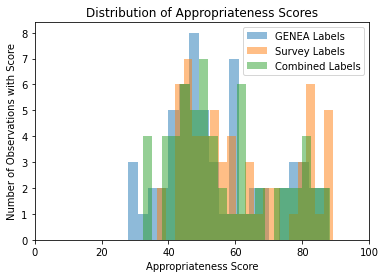

In [153]:
plt.hist(YY_genea, bins = 20, label='GENEA Labels', alpha=0.5)
plt.hist(YY_survey, bins = 20, label='Survey Labels', alpha=0.5)
plt.hist(YY_combined, bins = 20, label='Combined Labels', alpha=0.5)
plt.xlim(0,100)
plt.xlabel("Appropriateness Score")
plt.ylabel("Number of Observations with Score")
plt.title("Distribution of Appropriateness Scores")
plt.legend()